<div style="padding:20px;color:white;margin:0;font-size:175%;text-align:center;display:fill;border-radius:5px;background-color:#016CC9;overflow:hidden;font-weight:500">American Express Default Prediction</div>

# <b><span style='color:#4B4B4B'>1 |</span><span style='color:#016CC9'> Competition Objective</span></b>
Whether out at a restaurant or buying tickets to a concert, modern life counts on the convenience of a credit card to make daily purchases. It saves us from carrying large amounts of cash and also can advance a full purchase that can be paid over time. How do card issuers know we'll pay back what we charge? That's a complex problem with many existing solutions—and even more potential improvements, to be explored in this competition.

Credit default prediction is central to managing risk in a consumer lending business. Credit default prediction allows lenders to optimize lending decisions, which leads to a better customer experience and sound business economics. Current models exist to help manage risk. But it's possible to create better models that can outperform those currently in use.

American Express is a globally integrated payments company. The largest payment card issuer in the world, they provide customers with access to products, insights, and experiences that enrich lives and build business success.

The objective of [this competition](https://www.kaggle.com/competitions/amex-default-prediction) is to predict the probability that a customer does not pay back their credit card balance amount in the future based on their monthly customer profile. In this competition, you'll apply your machine learning skills to predict credit default. Specifically, you will leverage an industrial scale data set to build a machine learning model that challenges the current model in production. Training, validation, and testing datasets include time-series behavioral data and anonymized customer profile information. You're free to explore any technique to create the most powerful model, from creating features to using the data in a more organic way within a model.

If successful, you'll help create a better customer experience for cardholders by making it easier to be approved for a credit card. Top solutions could challenge the credit default prediction model used by the world's largest payment card issuer—earning you cash prizes, the opportunity to interview with American Express, and potentially a rewarding new career.

# <b><span style='color:#4B4B4B'>2 |</span><span style='color:#016CC9'> Data Overview</span></b>
The target binary variable is calculated by observing 18 months performance window after the latest credit card statement, and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.

The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:  
**`D_*`:** Delinquency variables  
**`S_*`:** Spend variables  
**`P_*`:** Payment variables  
**`B_*`:** Balance variables  
**`R_*`:** Risk variables  
With the following features being categorical: `B_30`, `B_38`, `D_63`, `D_64`, `D_66`, `D_68`, `D_114`, `D_116`, `D_117`, `D_120`, `D_126`. 

There are a total of 190 variables in the dataset with approximately 450,000 customers in the training set and 925,000 in the test set. Due to the dataset size, I will use the compressed version of the train and test sets provided by @munumbutt's [AMEX-Feather-Dataset](https://www.kaggle.com/datasets/munumbutt/amexfeather) and take the last statement for each customer.

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import roc_auc_score, roc_curve, auc
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import warnings, gc
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), 
                           height=500, width=1000))

train = pd.read_feather('../input/amexfeather/train_data.ftr')
train = train.groupby('customer_ID').tail(1).set_index('customer_ID')
print("The training data begins on {} and ends on {}.".format(train['S_2'].min().strftime('%m-%d-%Y'),train['S_2'].max().strftime('%m-%d-%Y')))
print("There are {:,.0f} customers in the training set and {} features.".format(train.shape[0],train.shape[1]))

test = pd.read_feather('../input/amexfeather/test_data.ftr')
test = test.groupby('customer_ID').tail(1).set_index('customer_ID')
print("\nThe test data begins on {} and ends on {}.".format(test['S_2'].min().strftime('%m-%d-%Y'),test['S_2'].max().strftime('%m-%d-%Y')))
print("There are {:,.0f} customers in the test set and {} features.".format(test.shape[0],test.shape[1]))

del test['S_2']
gc.collect()

titles=['Delinquency '+str(i).split('_')[1] if i.startswith('D') else 'Spend '+str(i).split('_')[1] 
        if i.startswith('S') else 'Payment '+str(i).split('_')[1]  if i.startswith('P') 
        else 'Balance '+str(i).split('_')[1] if i.startswith('B') else 
        'Risk '+str(i).split('_')[1] for i in train.columns[:-1]]
cat_cols=['Balance 30', 'Balance 38', 'Delinquency 63', 'Delinquency 64', 'Delinquency 66', 'Delinquency 68',
          'Delinquency 114', 'Delinquency 116', 'Delinquency 117', 'Delinquency 120', 'Delinquency 126', 'Target']
test.columns=titles[1:]
titles.append('Target')
train.columns=titles

The training data begins on 03-01-2018 and ends on 03-31-2018.
There are 458,913 customers in the training set and 190 features.

The test data begins on 04-01-2019 and ends on 10-31-2019.
There are 924,621 customers in the test set and 189 features.


In [5]:
train['D_63']

0          CR
1          CR
2          CR
3          CR
4          CR
           ..
5531446    CL
5531447    CL
5531448    CL
5531449    CL
5531450    CL
Name: D_63, Length: 5531451, dtype: category
Categories (6, object): ['CL', 'CO', 'CR', 'XL', 'XM', 'XZ']

In the training set, the last statement of all customers was in March 2018, while in the test set the date of customers' last statements range from April through October 2019. 

# <b><span style='color:#4B4B4B'>3 |</span><span style='color:#016CC9'> Exploratory Data Analysis</span></b>

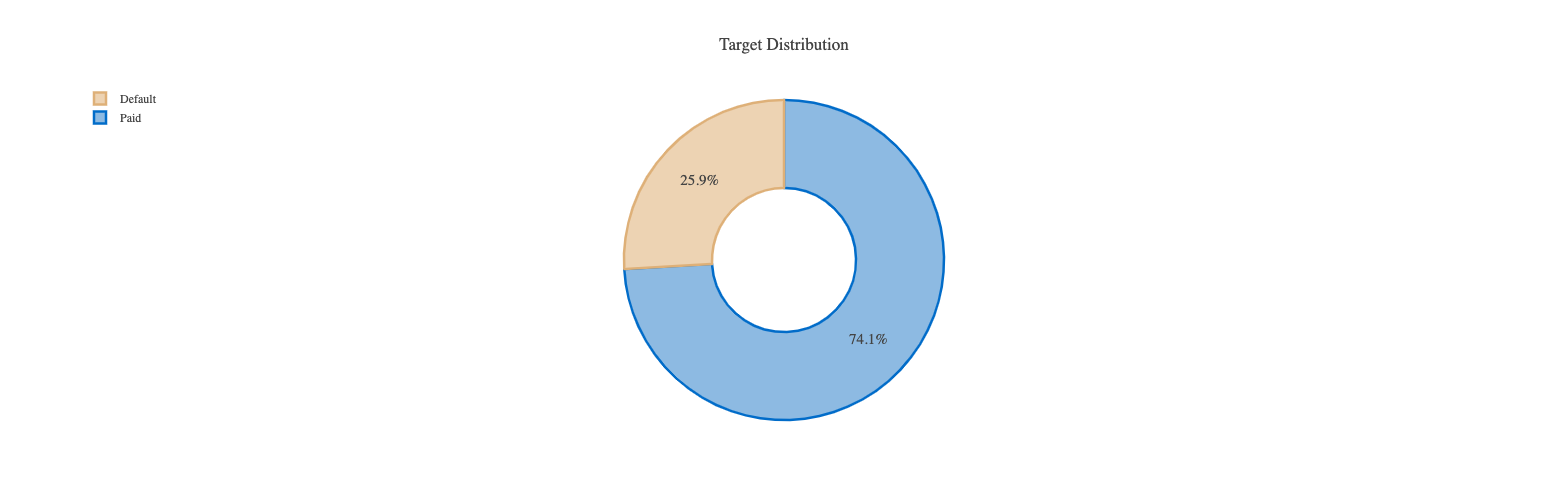

In [17]:
target=train.Target.value_counts(normalize=True)
target.rename(index={1:'Default',0:'Paid'},inplace=True)
pal, color=['#016CC9','#DEB078'], ['#8DBAE2','#EDD3B3']
fig=go.Figure()
fig.add_trace(go.Pie(labels=target.index, values=target*100, hole=.45, 
                     showlegend=True,sort=False, 
                     marker=dict(colors=color,line=dict(color=pal,width=2.5)),
                     hovertemplate = "%{label} Accounts: %{value:.2f}%<extra></extra>"))
fig.update_layout(template=temp, title='Target Distribution', 
                  legend=dict(traceorder='reversed',y=1.05,x=0),
                  uniformtext_minsize=15, uniformtext_mode='hide',width=700)
fig.show()

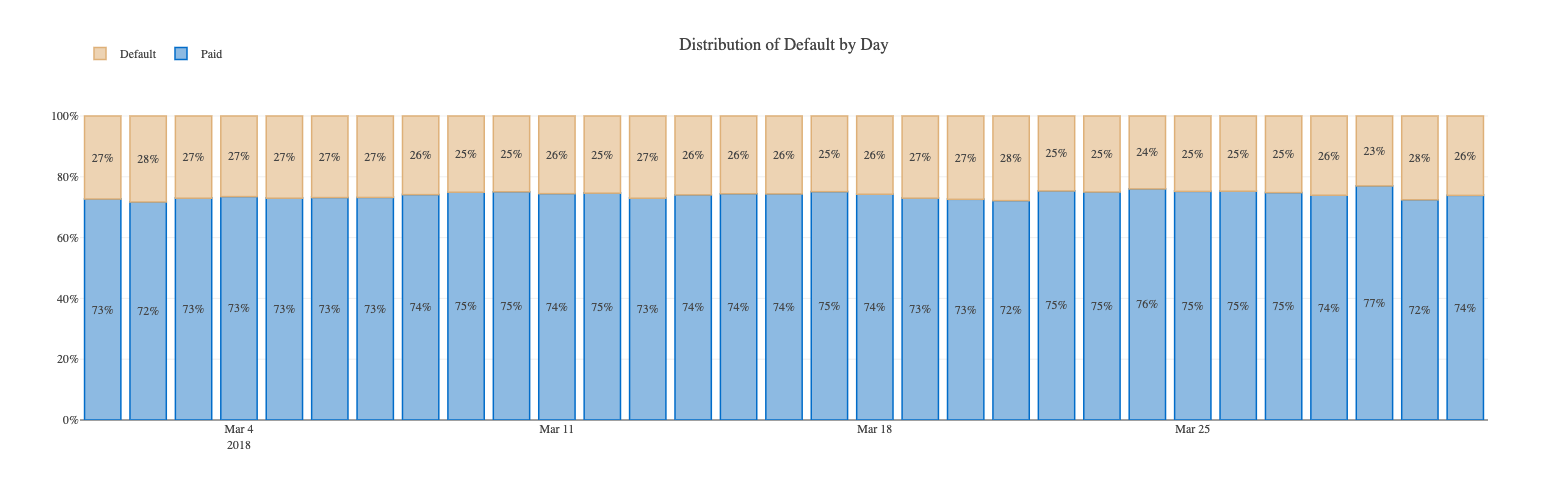

In [18]:
target=pd.DataFrame(data={'Default':train.groupby('Spend 2')['Target'].mean()*100})
target['Paid']=np.abs(train.groupby('Spend 2')['Target'].mean()-1)*100
rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.7)) for i in pal]
fig=go.Figure()
fig.add_trace(go.Bar(x=target.index, y=target.Paid, name='Paid',
                     text=target.Paid, texttemplate='%{text:.0f}%', 
                     textposition='inside',insidetextanchor="middle",
                     marker=dict(color=color[0],line=dict(color=pal[0],width=1.5)),
                     hovertemplate = "<b>%{x}</b><br>Paid accounts: %{y:.2f}%"))
fig.add_trace(go.Bar(x=target.index, y=target.Default, name='Default',
                     text=target.Default, texttemplate='%{text:.0f}%', 
                     textposition='inside',insidetextanchor="middle",
                     marker=dict(color=color[1],line=dict(color=pal[1],width=1.5)),
                     hovertemplate = "<b>%{x}</b><br>Default accounts: %{y:.2f}%"))
fig.update_layout(template=temp,title='Distribution of Default by Day', 
                  barmode='relative', yaxis_ticksuffix='%', width=1400,
                  legend=dict(orientation="h", traceorder="reversed", yanchor="bottom",y=1.1,xanchor="left", x=0))
fig.show()

About 25% of customers in the training data have defaulted. This proportion is consistent across each day in the training set, with a weekly seasonal trend in the day of the month when customers receive their statements.

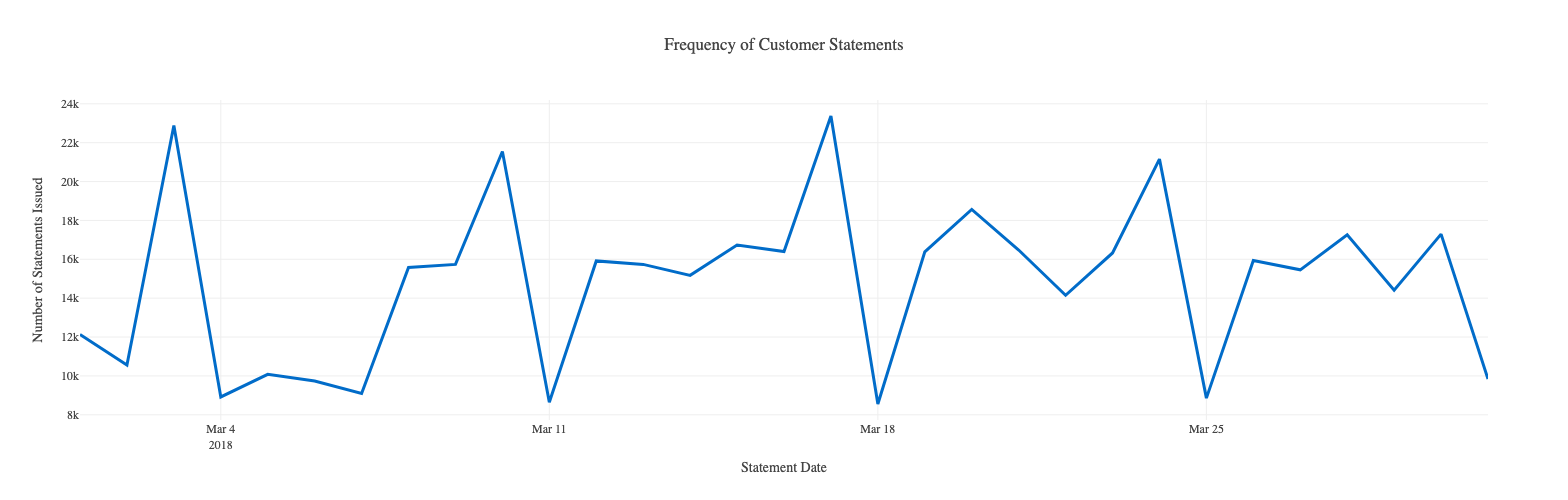

In [19]:
plot_df=train.reset_index().groupby('Spend 2')['customer_ID'].nunique().reset_index()
fig=go.Figure()
fig.add_trace(go.Scatter(x=plot_df['Spend 2'], 
                         y=plot_df['customer_ID'], mode='lines',
                         line=dict(color=pal[0], width=3), 
                         hovertemplate = ''))
fig.update_layout(template=temp, title="Frequency of Customer Statements", 
                  hovermode="x unified", width=800,height=500,
                  xaxis_title='Statement Date', yaxis_title='Number of Statements Issued')
fig.show()
del train['Spend 2']

# <b><div style='padding:15px;background-color:#4B4B4B;color:white;border-radius:5px;font-size:60%'>3.1 EDA of Delinquency Variables</div></b>

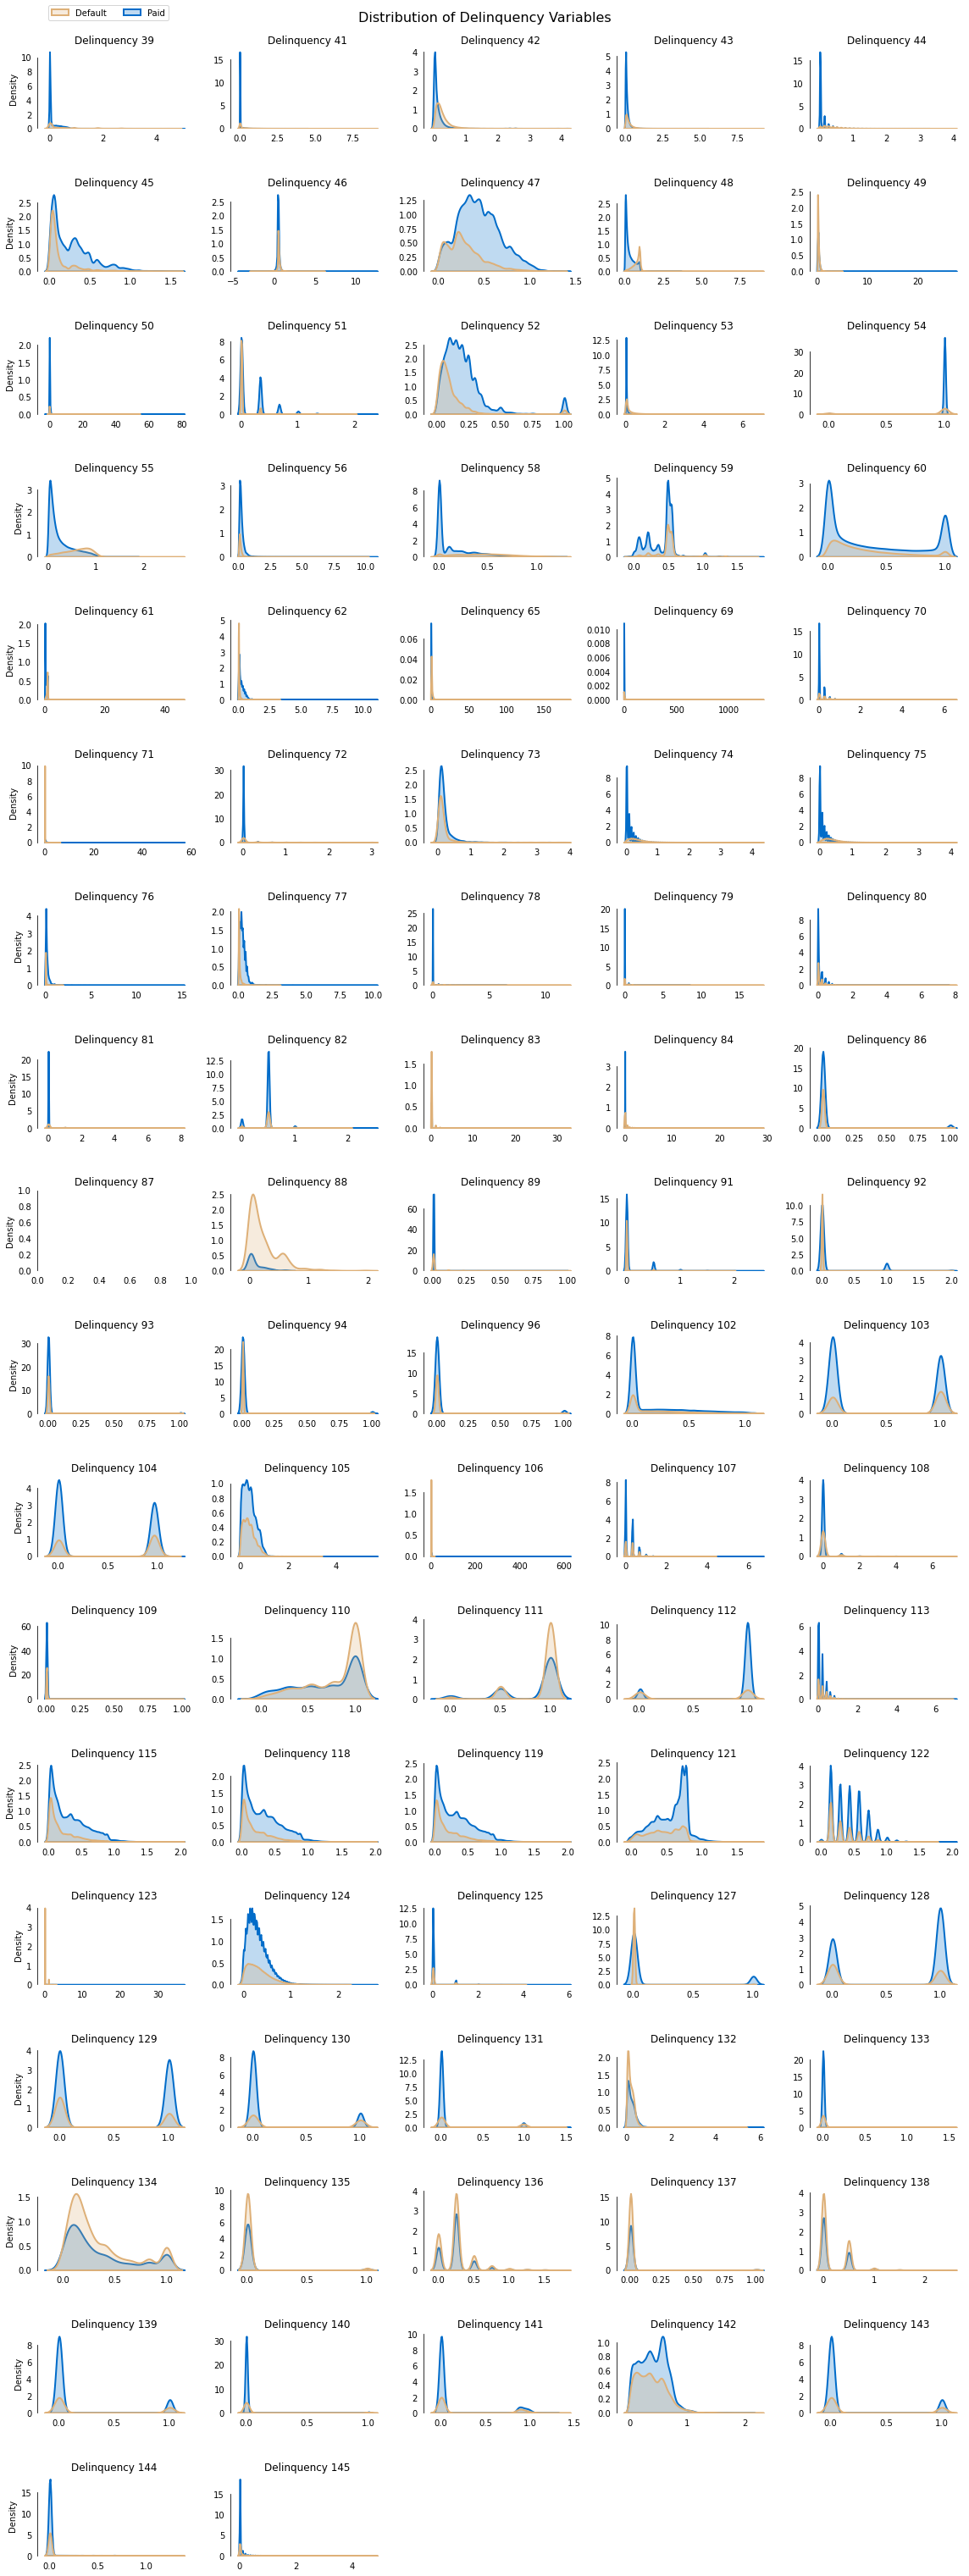

In [20]:
cols=[col for col in train.columns if (col.startswith(('D','T'))) & (col not in cat_cols[:-1])]
plot_df=train[cols]
fig, ax = plt.subplots(18,5, figsize=(16,54))
fig.suptitle('Distribution of Delinquency Variables',fontsize=16)
row=0
col=[0,1,2,3,4]*18
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='Target', palette=pal[::-1], hue_order=[1,0], 
                label=['Default','Paid'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%5==0 else ''))
for i in range(2,5):
    ax[17,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.983))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

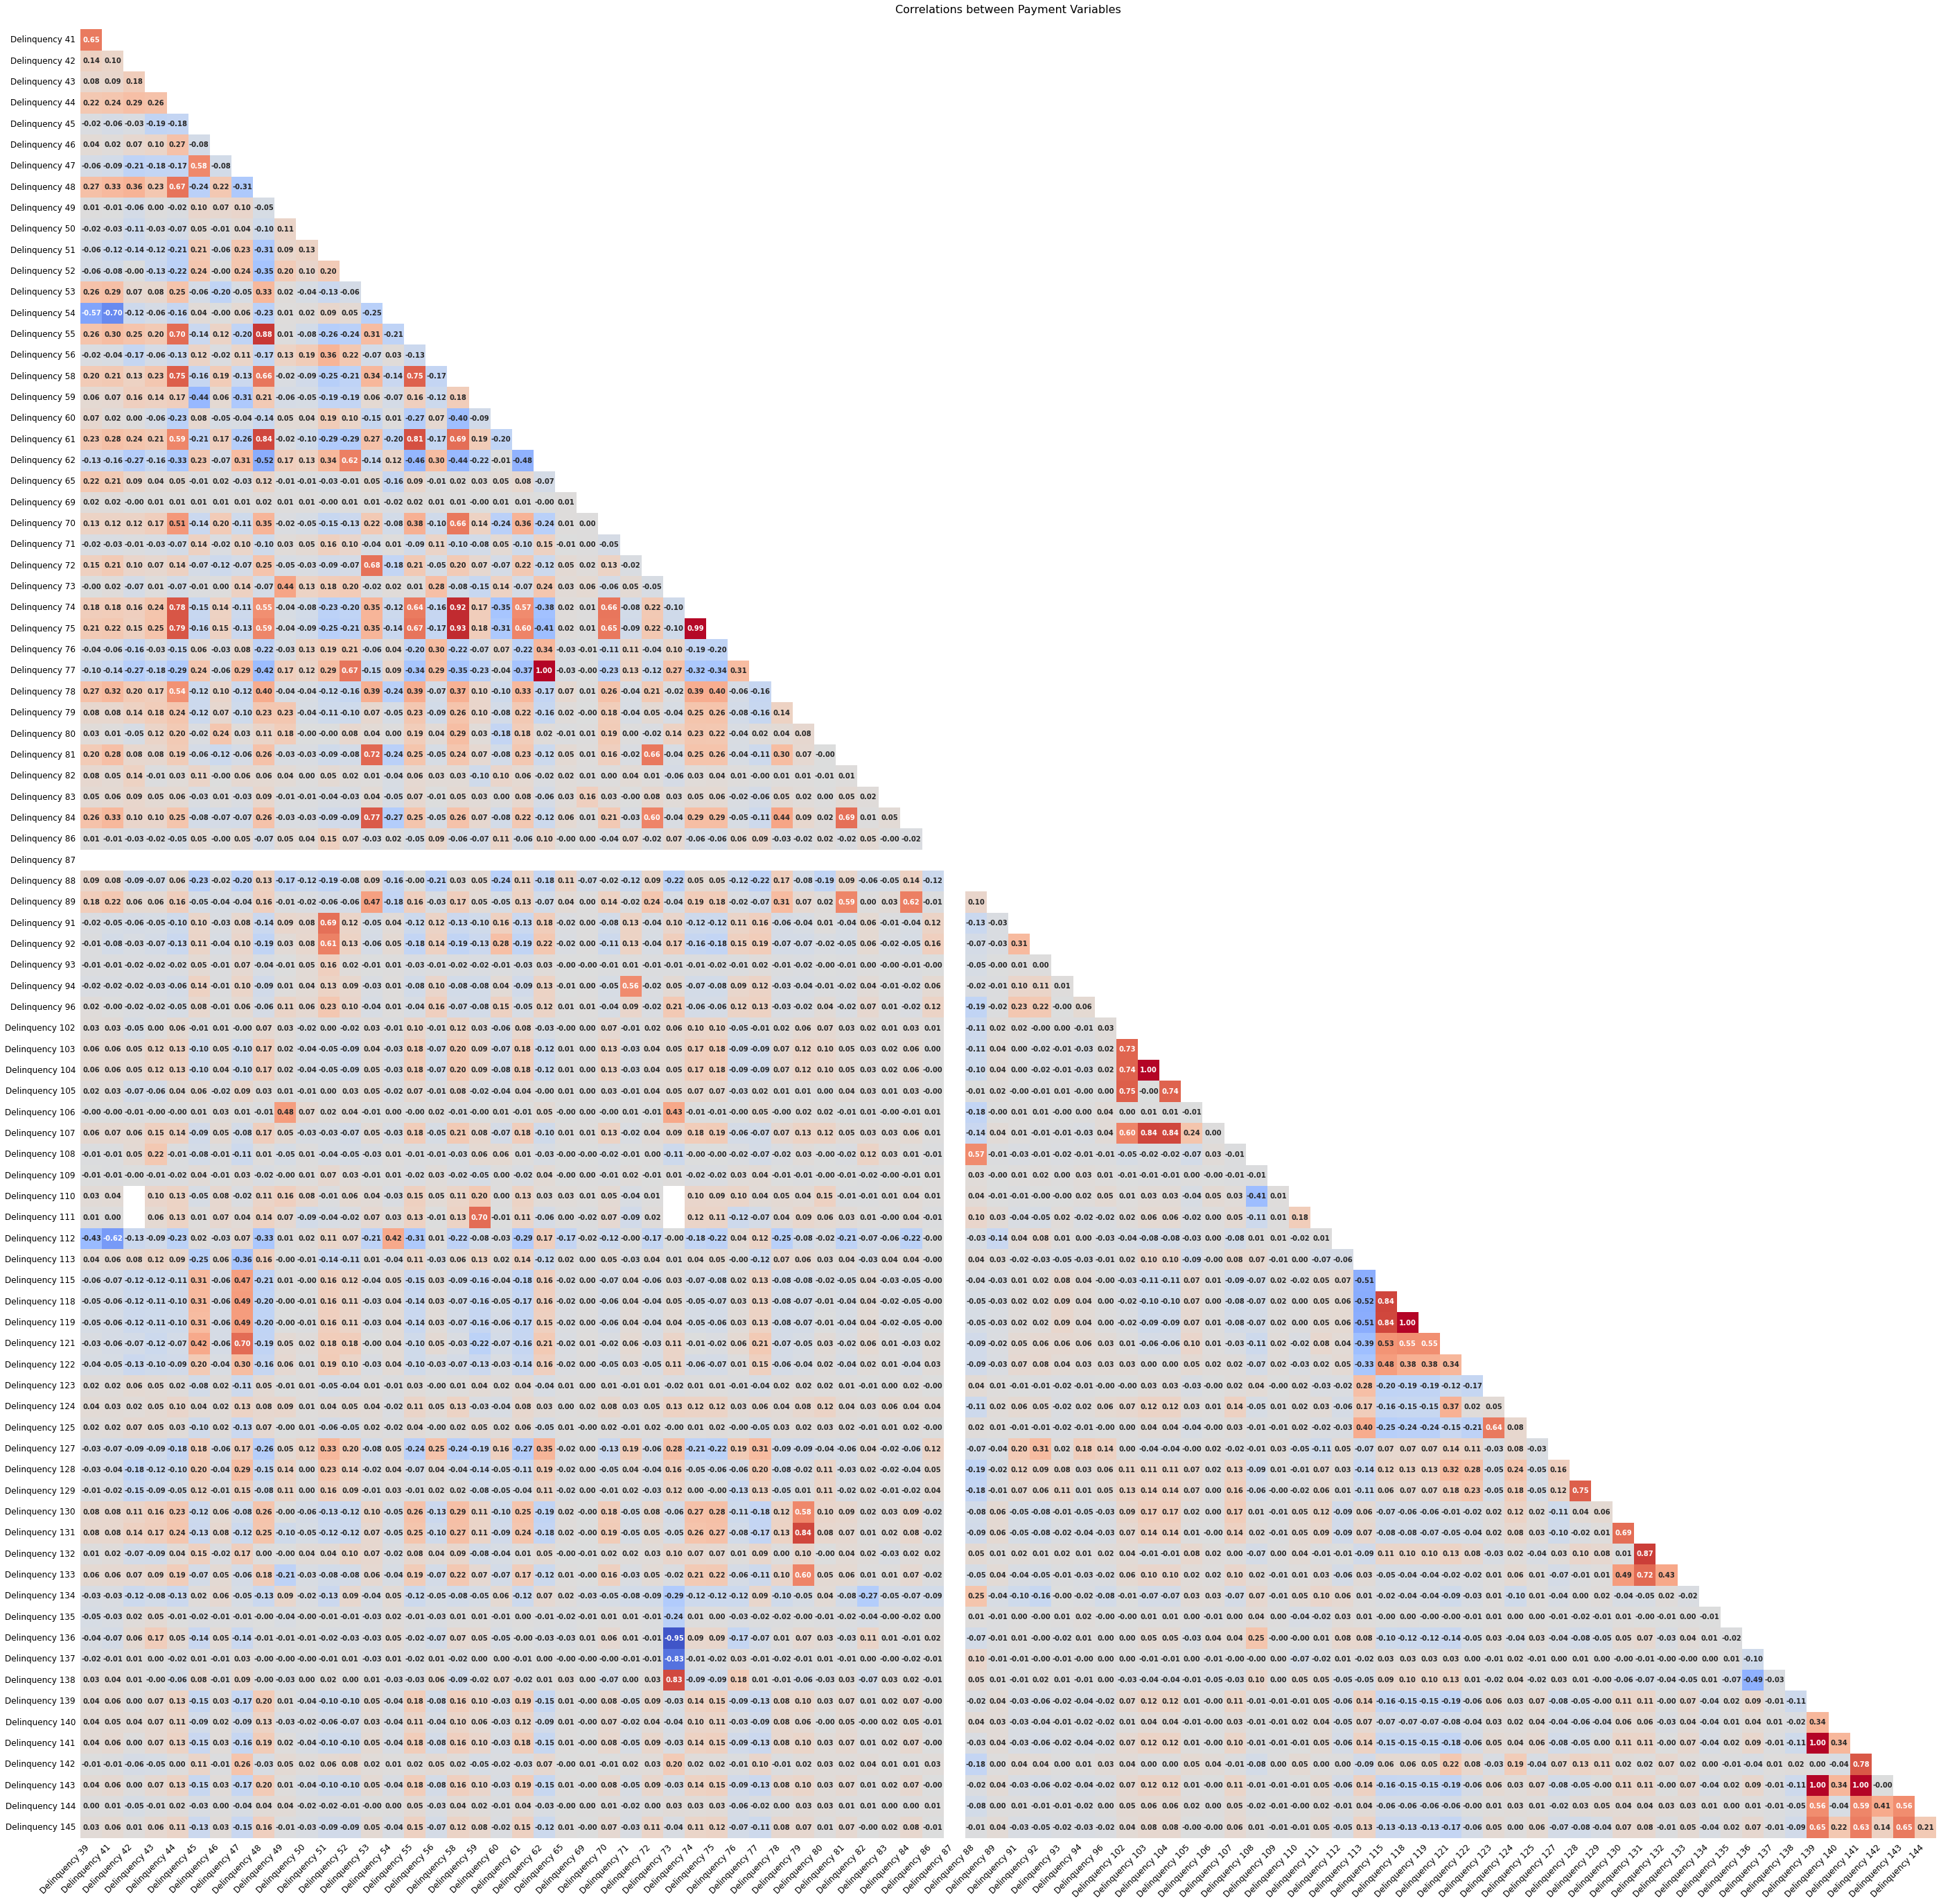

In [21]:
corr=plot_df.iloc[:,:-1].corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots(figsize=(48,48))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':10,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlations between Payment Variables\n', fontsize=16)
fig.show()

There are several highly correlated Delinquency variables, with a few pairs perfectly positively correlated at 1.0. There are also a number of missing correlations, particularly in `Delinquency 87`, due to null values in the data. Below are the relationships between some of the most correlated Delinquency variables. 

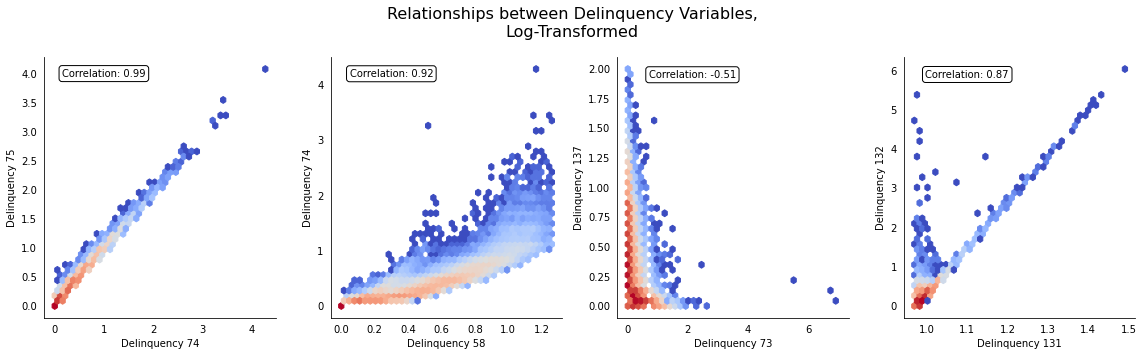

In [22]:
fig, ax = plt.subplots(1,4, figsize=(16,5))
fig.suptitle('Relationships between Delinquency Variables,\nLog-Transformed',fontsize=16)
ax[0].hexbin(x='Delinquency 74', y='Delinquency 75', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[0].set(xlabel='Delinquency 74',ylabel='Delinquency 75')
ax[0].text(1, 4, 'Correlation: {:.2f}'.format(plot_df[['Delinquency 74','Delinquency 75']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[1].hexbin(x='Delinquency 58', y='Delinquency 74', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[1].set(xlabel='Delinquency 58',ylabel='Delinquency 74')
ax[1].text(0.3, 4.2, 'Correlation: {:.2f}'.format(plot_df[['Delinquency 58','Delinquency 74']].corr().iloc[1,0]),
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[2].hexbin(x='Delinquency 113', y='Delinquency 115', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[2].set(xlabel='Delinquency 73',ylabel='Delinquency 137')
ax[2].text(2.15, 1.95, 'Correlation: {:.2f}'.format(plot_df[['Delinquency 113','Delinquency 115']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[3].hexbin(x='Delinquency 131', y='Delinquency 132', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[3].set(xlabel='Delinquency 131',ylabel='Delinquency 132')
ax[3].text(1.1, 5.9, 'Correlation: {:.2f}'.format(plot_df[['Delinquency 131','Delinquency 132']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
for i in range(4):
    ax[i].tick_params(left=False,bottom=False)
sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

# <b><div style='padding:15px;background-color:#4B4B4B;color:white;border-radius:5px;font-size:60%'>3.2 EDA of Spend Variables</div></b>

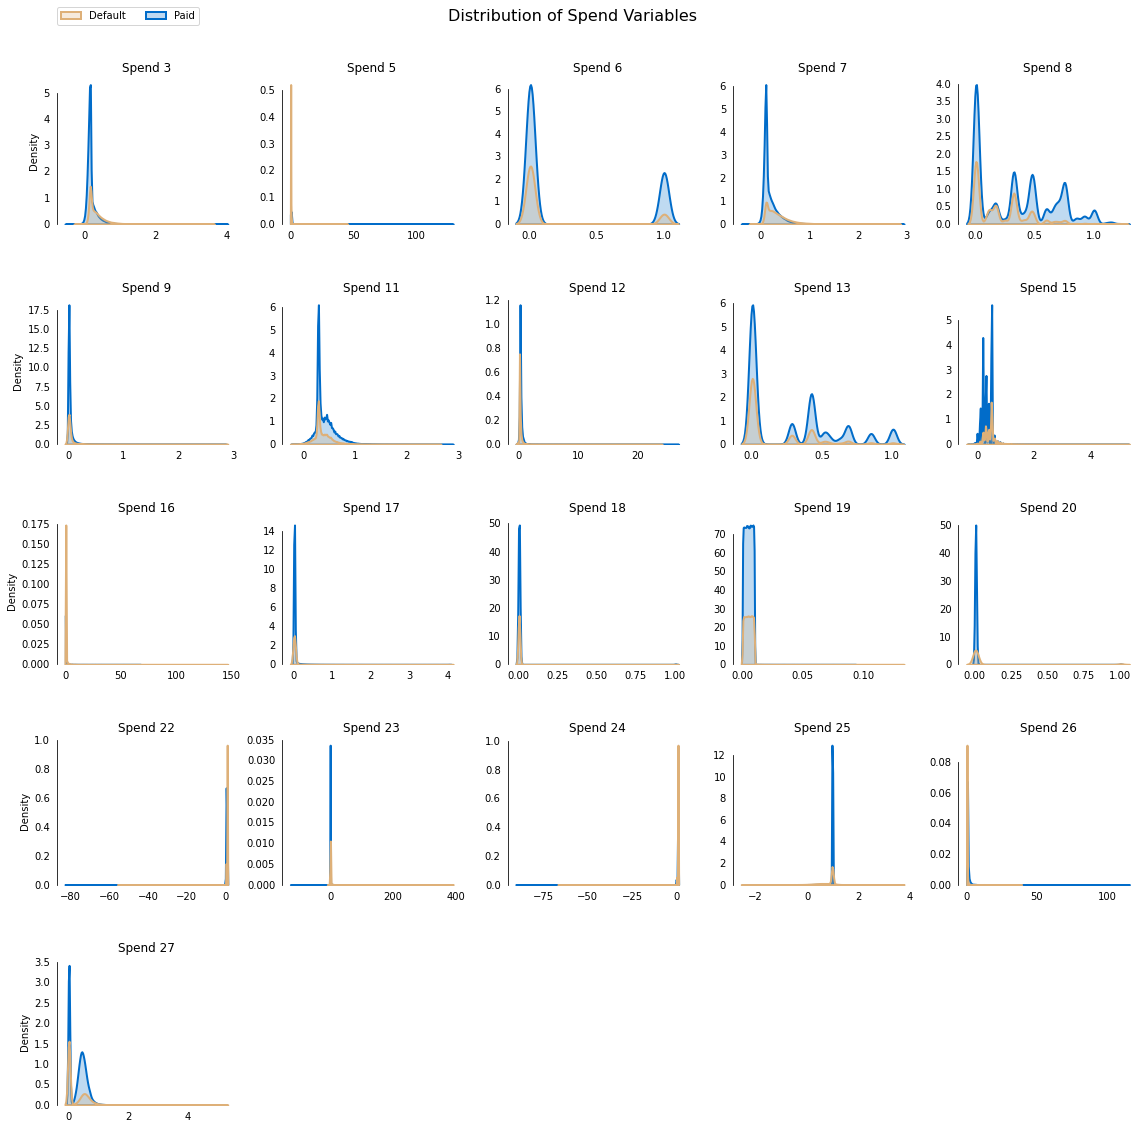

In [23]:
cols=[col for col in train.columns if (col.startswith(('S','T'))) & (col not in cat_cols[:-1])]
plot_df=train[cols]
fig, ax = plt.subplots(5,5, figsize=(16,20))
fig.suptitle('Distribution of Spend Variables',fontsize=16)
row=0
col=[0,1,2,3,4]*5
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='Target', palette=pal[::-1], hue_order=[1,0], 
                label=['Default','Paid'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%5==0 else ''))
for i in range(1,5):
    ax[4,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.985))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

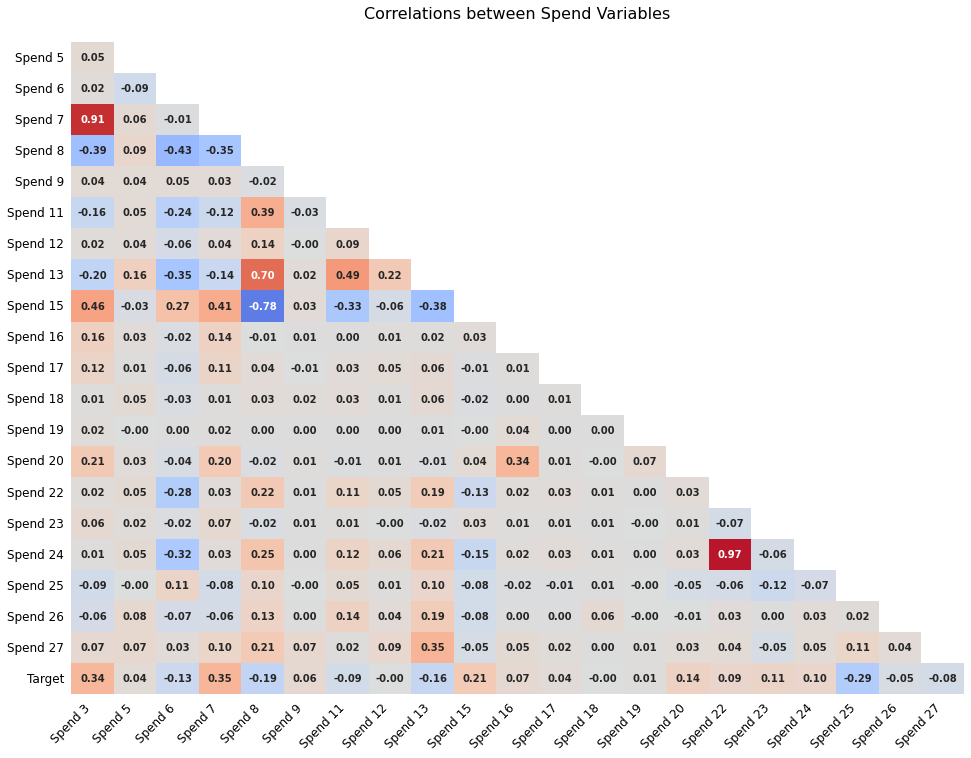

In [24]:
corr=plot_df.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots(figsize=(16,12))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':10,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlations between Spend Variables\n', fontsize=16)
fig.show()

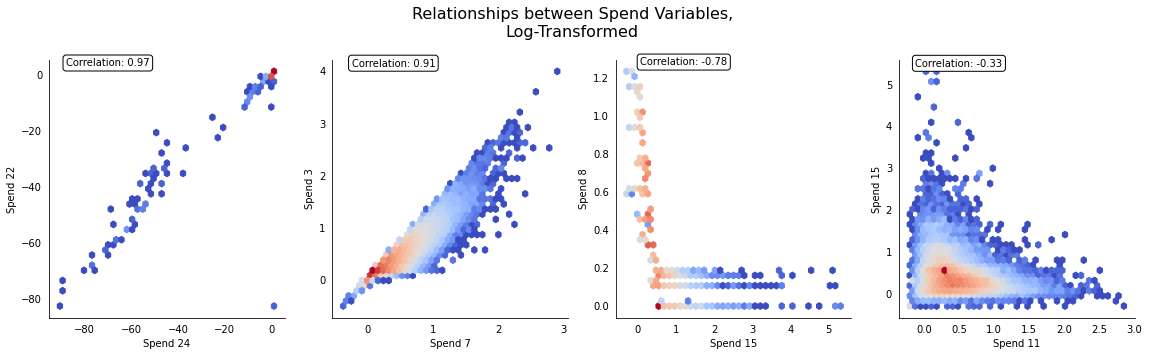

In [25]:
fig, ax = plt.subplots(1,4, figsize=(16,5))
fig.suptitle('Relationships between Spend Variables,\nLog-Transformed',fontsize=16)
ax[0].hexbin(x='Spend 24', y='Spend 22', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[0].set(xlabel='Spend 24',ylabel='Spend 22')
ax[0].text(-70, 4, 'Correlation: {:.2f}'.format(plot_df[['Spend 24','Spend 22']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[1].hexbin(x='Spend 7', y='Spend 3', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[1].set(xlabel='Spend 7',ylabel='Spend 3')
ax[1].text(0.4, 4.15, 'Correlation: {:.2f}'.format(plot_df[['Spend 7','Spend 3']].corr().iloc[1,0]),
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[2].hexbin(x='Spend 15', y='Spend 8', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[2].set(xlabel='Spend 15',ylabel='Spend 8')
ax[2].text(1.2, 1.28, 'Correlation: {:.2f}'.format(plot_df[['Spend 15','Spend 8']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[3].hexbin(x='Spend 11', y='Spend 15', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[3].set(xlabel='Spend 11',ylabel='Spend 15')
ax[3].text(.5,5.5, 'Correlation: {:.2f}'.format(plot_df[['Spend 11','Spend 15']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
for i in range(4):
    ax[i].tick_params(left=False,bottom=False)
sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

# <b><div style='padding:15px;background-color:#4B4B4B;color:white;border-radius:5px;font-size:60%'>3.3 EDA of Payment Variables</div></b>

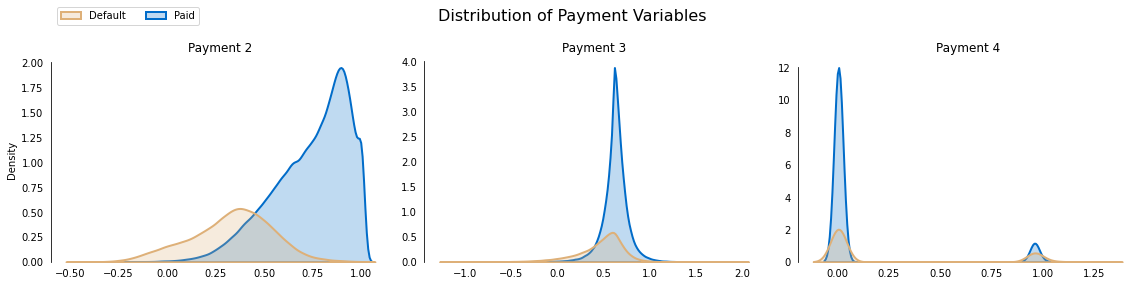

In [26]:
cols=[col for col in train.columns if (col.startswith(('P','T'))) & (col not in cat_cols[:-1])]
plot_df=train[cols]
fig, ax = plt.subplots(1,3, figsize=(16,5))
fig.suptitle('Distribution of Payment Variables',fontsize=16)
for i, col in enumerate(plot_df.columns[:-1]):
    sns.kdeplot(x=col, hue='Target', palette=pal[::-1], hue_order=[1,0], 
                label=['Default','Paid'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[i])
    ax[i].tick_params(left=False,bottom=False)
    ax[i].set(title='{}'.format(col), xlabel='', ylabel=('Density' if i==0 else ''))
handles, _ = ax[0].get_legend_handles_labels() 
fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 1))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

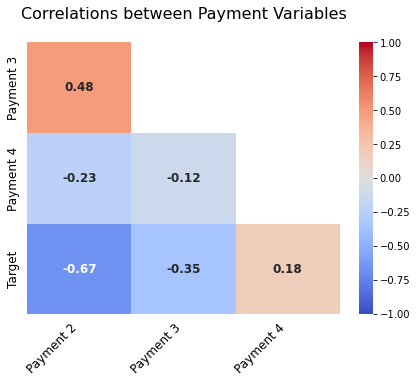

In [27]:
corr=plot_df.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots(figsize=(7,5)) 
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':12,'fontweight':'bold'})
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlations between Payment Variables\n', fontsize=16)
fig.show()

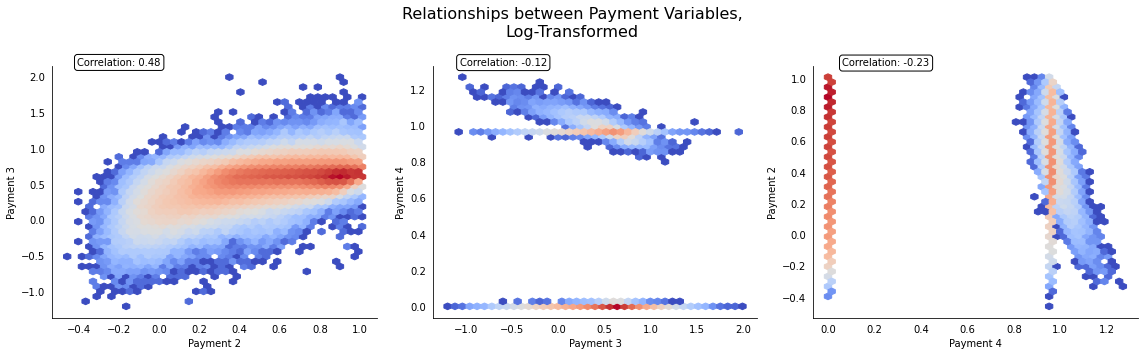

In [28]:
fig, ax = plt.subplots(1,3, figsize=(16,5))
fig.suptitle('Relationships between Payment Variables,\nLog-Transformed',fontsize=16)
ax[0].hexbin(x='Payment 2', y='Payment 3', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[0].text(-.2,2.2, 'Correlation: {:.2f}'.format(plot_df[['Payment 2','Payment 3']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[0].set(xlabel='Payment 2',ylabel='Payment 3')
ax[1].hexbin(x='Payment 3', y='Payment 4', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[1].text(-.6,1.35, 'Correlation: {:.2f}'.format(plot_df[['Payment 3','Payment 4']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[1].set(xlabel='Payment 3',ylabel='Payment 4')
ax[2].hexbin(x='Payment 4', y='Payment 2', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[2].text(.25,1.1, 'Correlation: {:.2f}'.format(plot_df[['Payment 4','Payment 2']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[2].set(xlabel='Payment 4',ylabel='Payment 2')
for i in range(3):
    ax[i].tick_params(left=False,bottom=False)
sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

# <b><div style='padding:15px;background-color:#4B4B4B;color:white;border-radius:5px;font-size:60%'>3.4 EDA of Balance Variables</div></b>

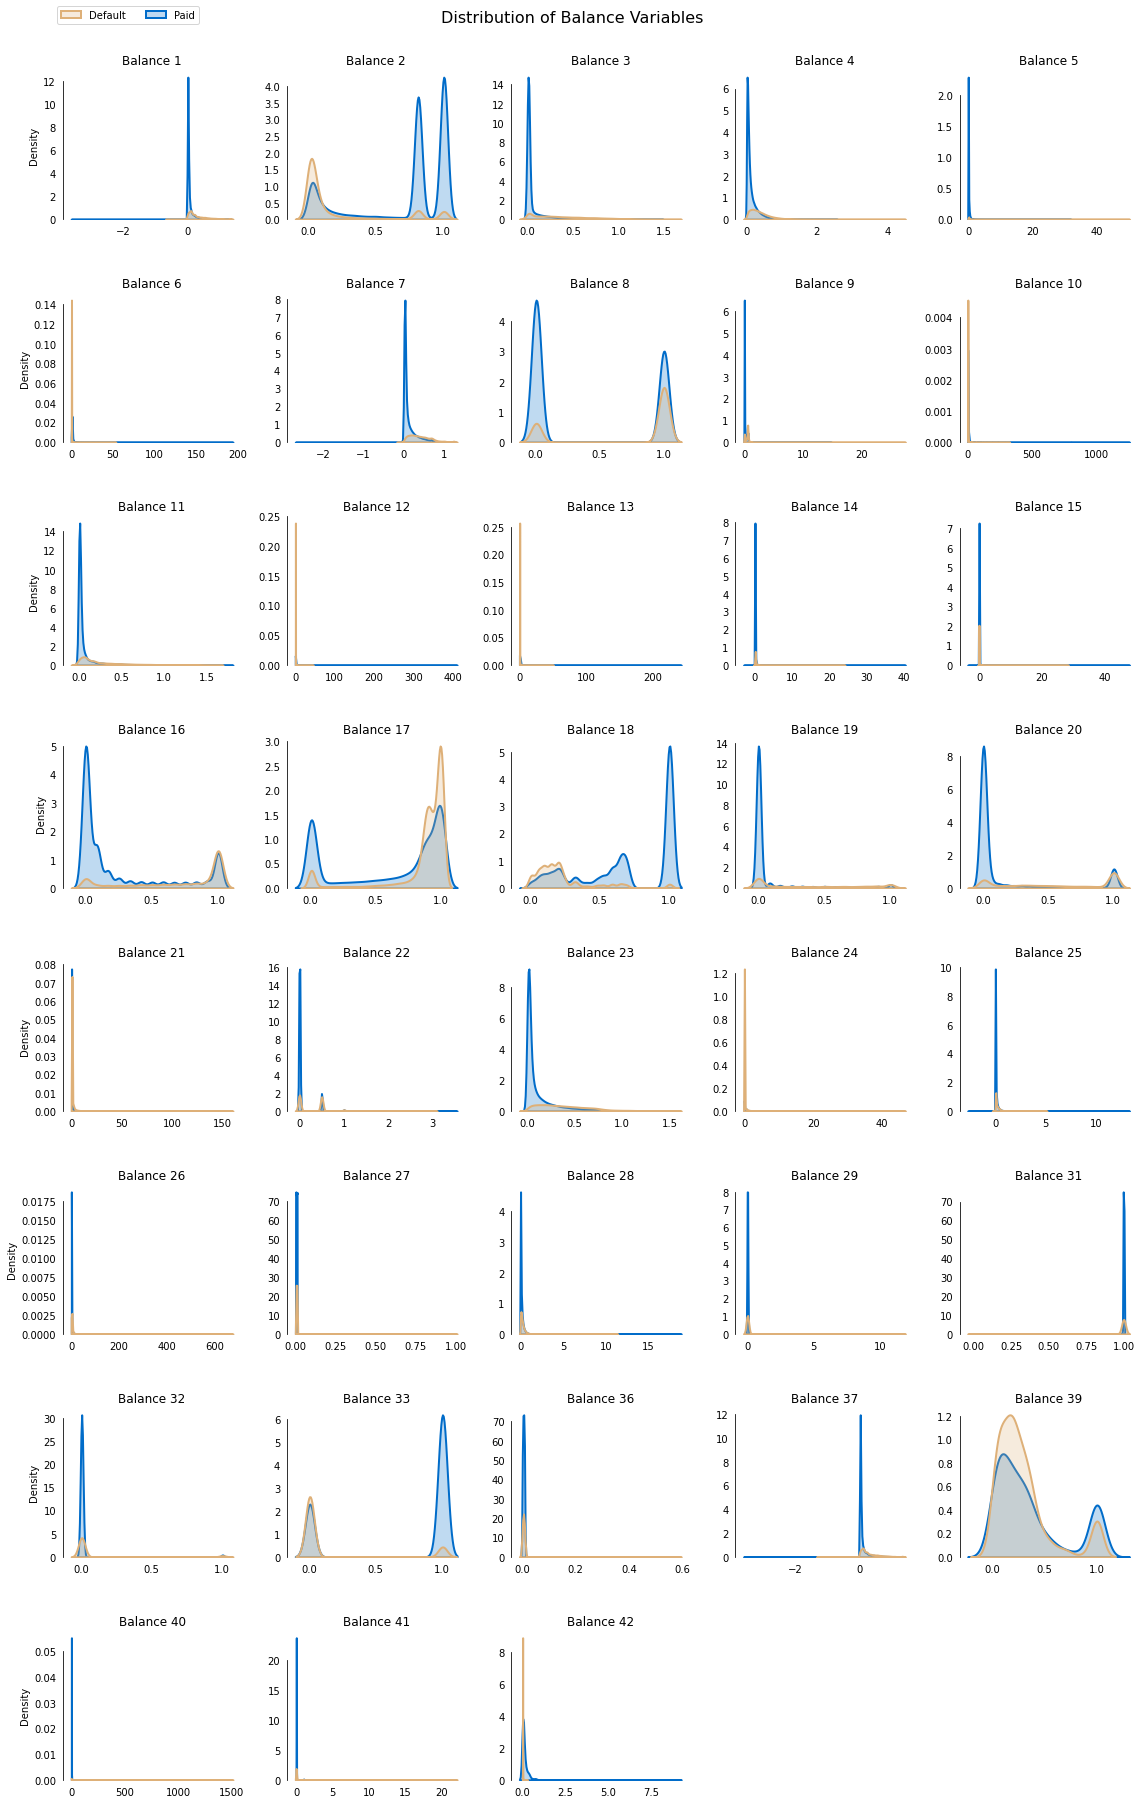

In [29]:
cols=[col for col in train.columns if (col.startswith(('B','T'))) & (col not in cat_cols[:-1])]
plot_df=train[cols]
fig, ax = plt.subplots(8,5, figsize=(16,32))
fig.suptitle('Distribution of Balance Variables',fontsize=16)
row=0
col=[0,1,2,3,4]*8
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='Target', palette=pal[::-1], hue_order=[1,0], 
                label=['Default','Paid'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%5==0 else ''))
for i in range(3,5):
    ax[7,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.984))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

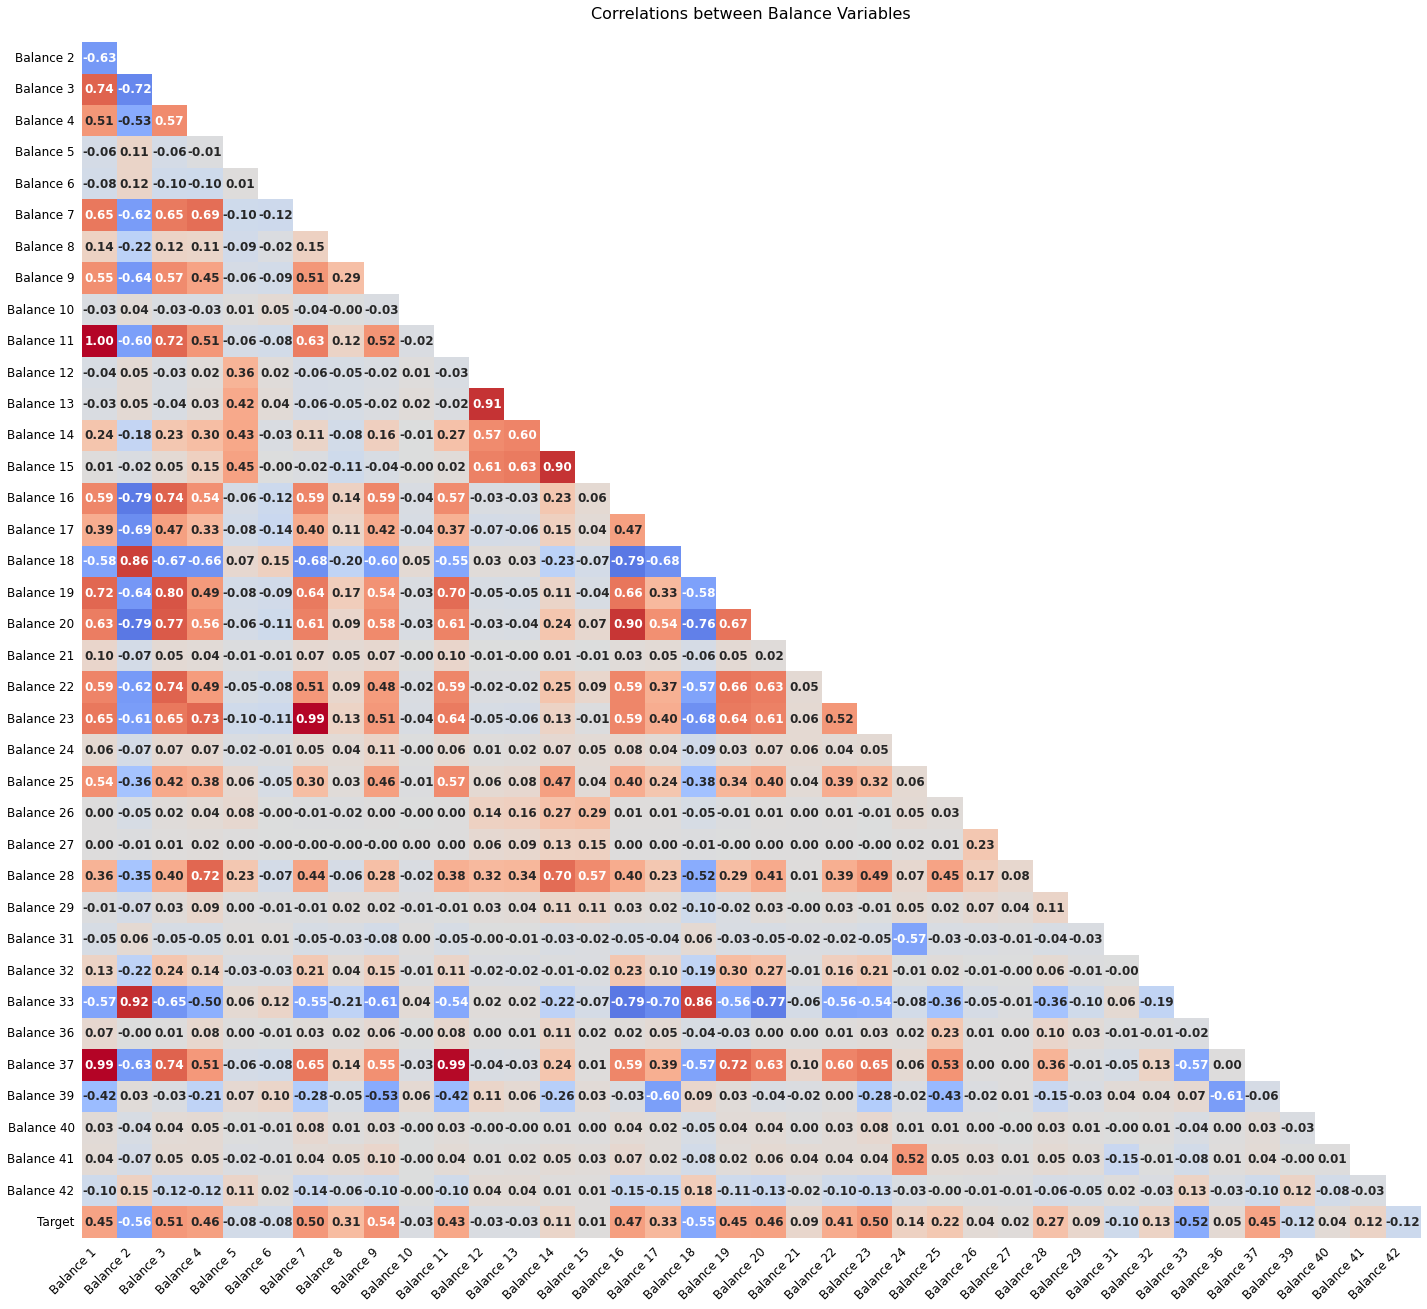

In [30]:
corr=plot_df.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots(figsize=(24,22))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':12,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlations between Balance Variables\n', fontsize=16)
fig.show()

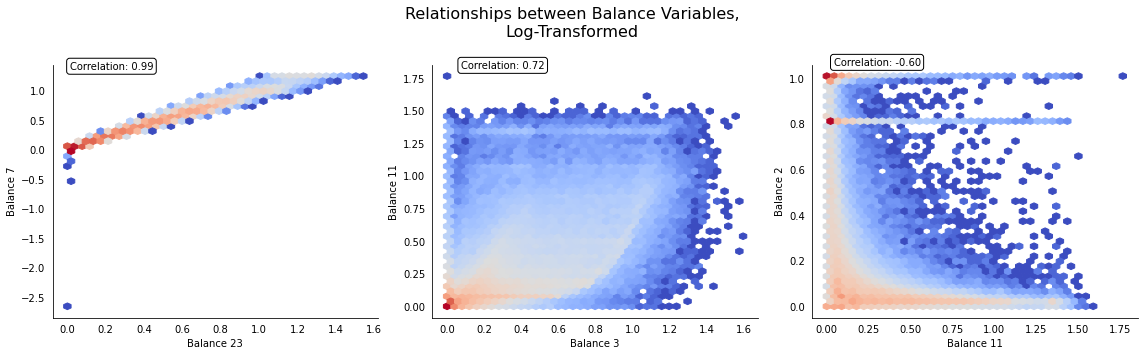

In [31]:
fig, ax = plt.subplots(1,3, figsize=(16,5))
fig.suptitle('Relationships between Balance Variables,\nLog-Transformed',fontsize=16)
ax[0].hexbin(x='Balance 23', y='Balance 7', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[0].text(.23,1.42, 'Correlation: {:.2f}'.format(plot_df[['Balance 23','Balance 7']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[0].set(xlabel='Balance 23',ylabel='Balance 7')
ax[1].hexbin(x='Balance 3', y='Balance 11', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[1].text(.3,1.85, 'Correlation: {:.2f}'.format(plot_df[['Balance 3','Balance 11']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[1].set(xlabel='Balance 3',ylabel='Balance 11')
ax[2].hexbin(x='Balance 11', y='Balance 2', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[2].text(.3,1.07, 'Correlation: {:.2f}'.format(plot_df[['Balance 11','Balance 2']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[2].set(xlabel='Balance 11',ylabel='Balance 2')
for i in range(3):
    ax[i].tick_params(left=False,bottom=False)
sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

# <b><div style='padding:15px;background-color:#4B4B4B;color:white;border-radius:5px;font-size:60%'>3.5 EDA of Risk Variables</div></b>

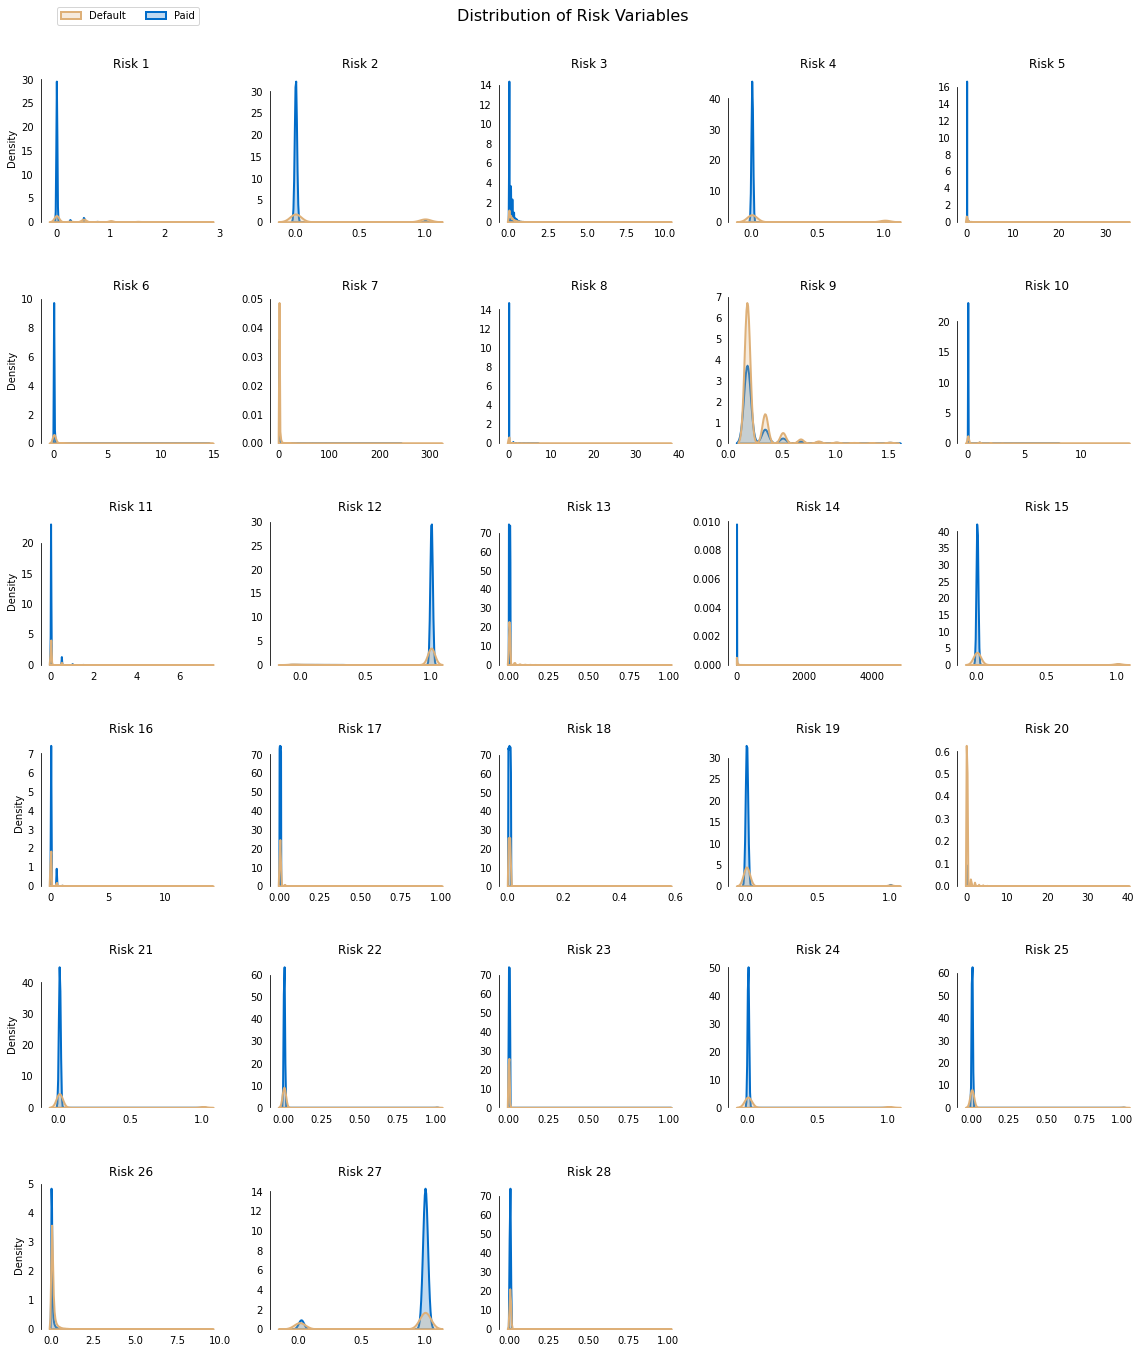

In [32]:
cols=[col for col in train.columns if (col.startswith(('R','T'))) & (col not in cat_cols[:-1])]
plot_df=train[cols]
fig, ax = plt.subplots(6,5, figsize=(16,24))
fig.suptitle('Distribution of Risk Variables',fontsize=16)
row=0
col=[0,1,2,3,4]*6
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='Target', palette=pal[::-1], hue_order=[1,0], 
                label=['Default','Paid'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%5==0 else ''))
for i in range(3,5):
    ax[5,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.984))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

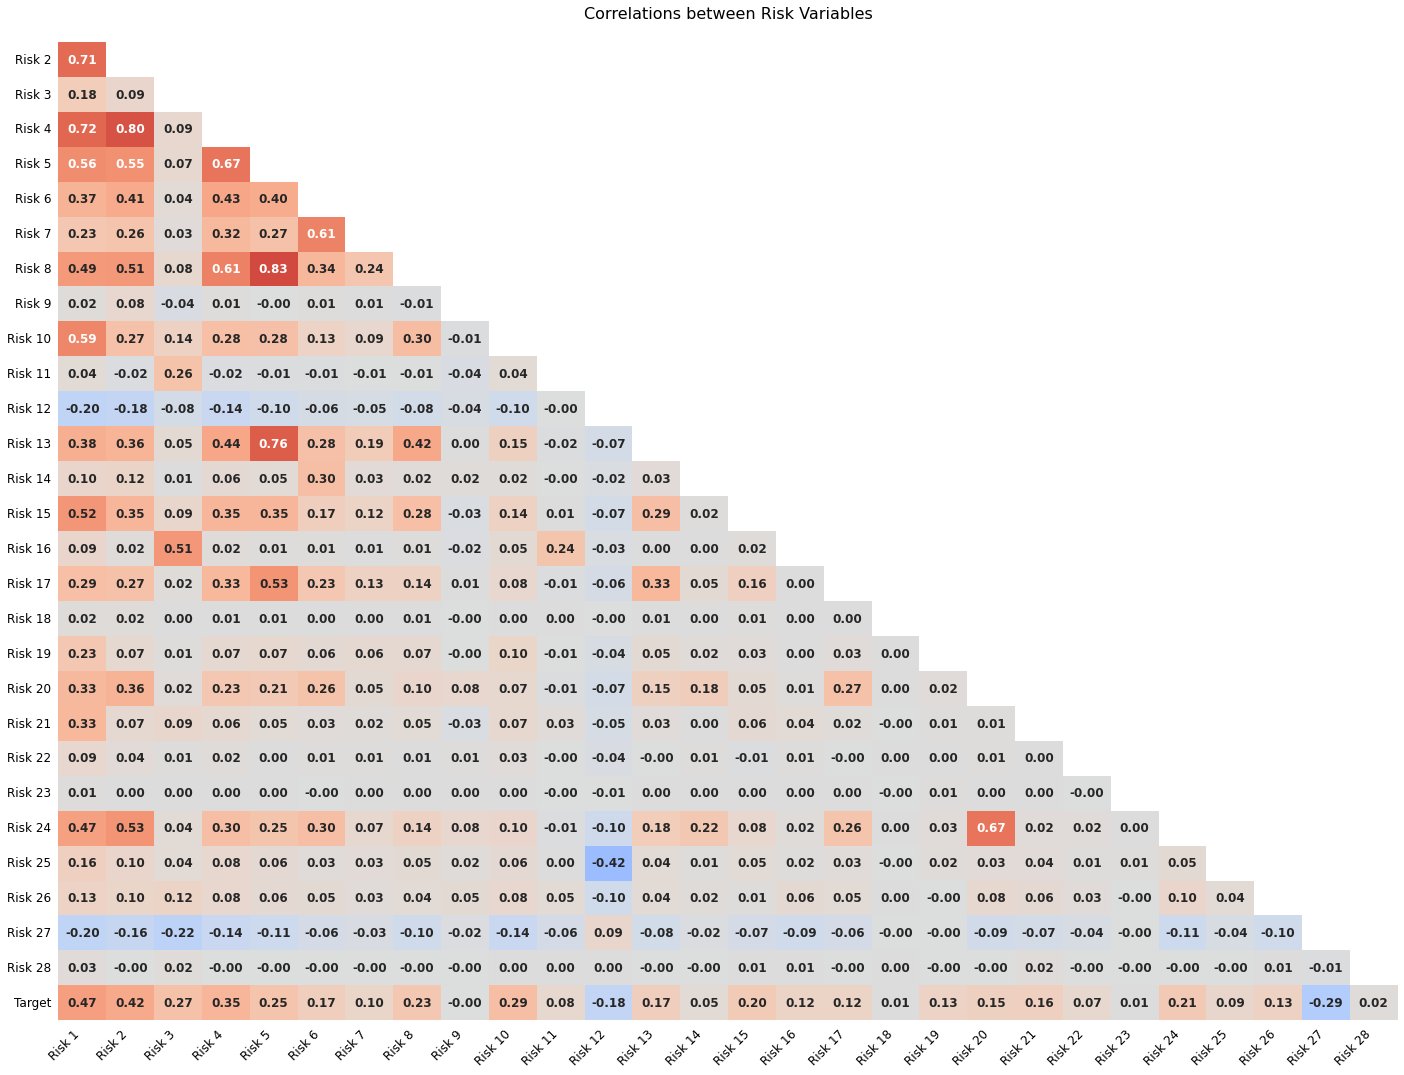

In [33]:
corr=plot_df.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots(figsize=(24,18))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':12,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlations between Risk Variables\n', fontsize=16)
fig.show()

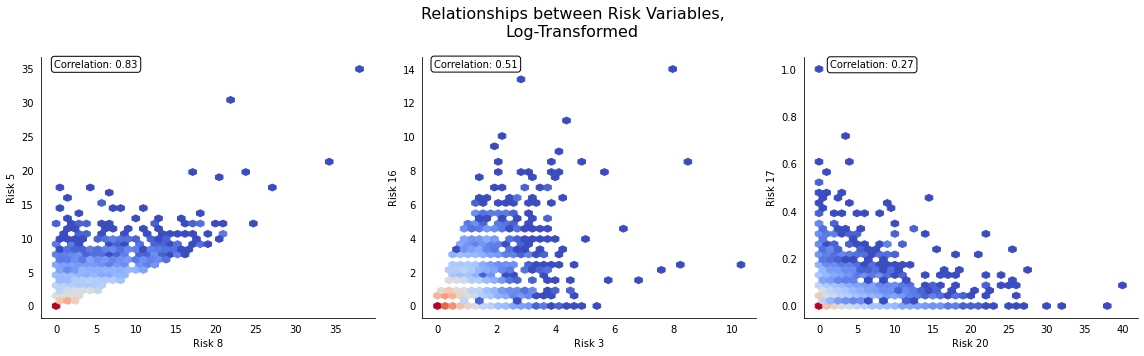

In [34]:
fig, ax = plt.subplots(1,3, figsize=(16,5))
fig.suptitle('Relationships between Risk Variables,\nLog-Transformed',fontsize=16)
ax[0].hexbin(x='Risk 8', y='Risk 5', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[0].text(5,35.7, 'Correlation: {:.2f}'.format(plot_df[['Risk 8','Risk 5']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[0].set(xlabel='Risk 8',ylabel='Risk 5')
ax[1].hexbin(x='Risk 3', y='Risk 16', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[1].text(1.3,14.3, 'Correlation: {:.2f}'.format(plot_df[['Risk 3','Risk 16']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[1].set(xlabel='Risk 3',ylabel='Risk 16')
ax[2].hexbin(x='Risk 20', y='Risk 17', data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
ax[2].text(7,1.02, 'Correlation: {:.2f}'.format(plot_df[['Risk 20','Risk 17']].corr().iloc[1,0]), 
           ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
ax[2].set(xlabel='Risk 20',ylabel='Risk 17')
for i in range(3):
    ax[i].tick_params(left=False,bottom=False)
sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

# <b><div style='padding:15px;background-color:#4B4B4B;color:white;border-radius:5px;font-size:60%'>3.6 EDA of Categorical Variables</div></b>

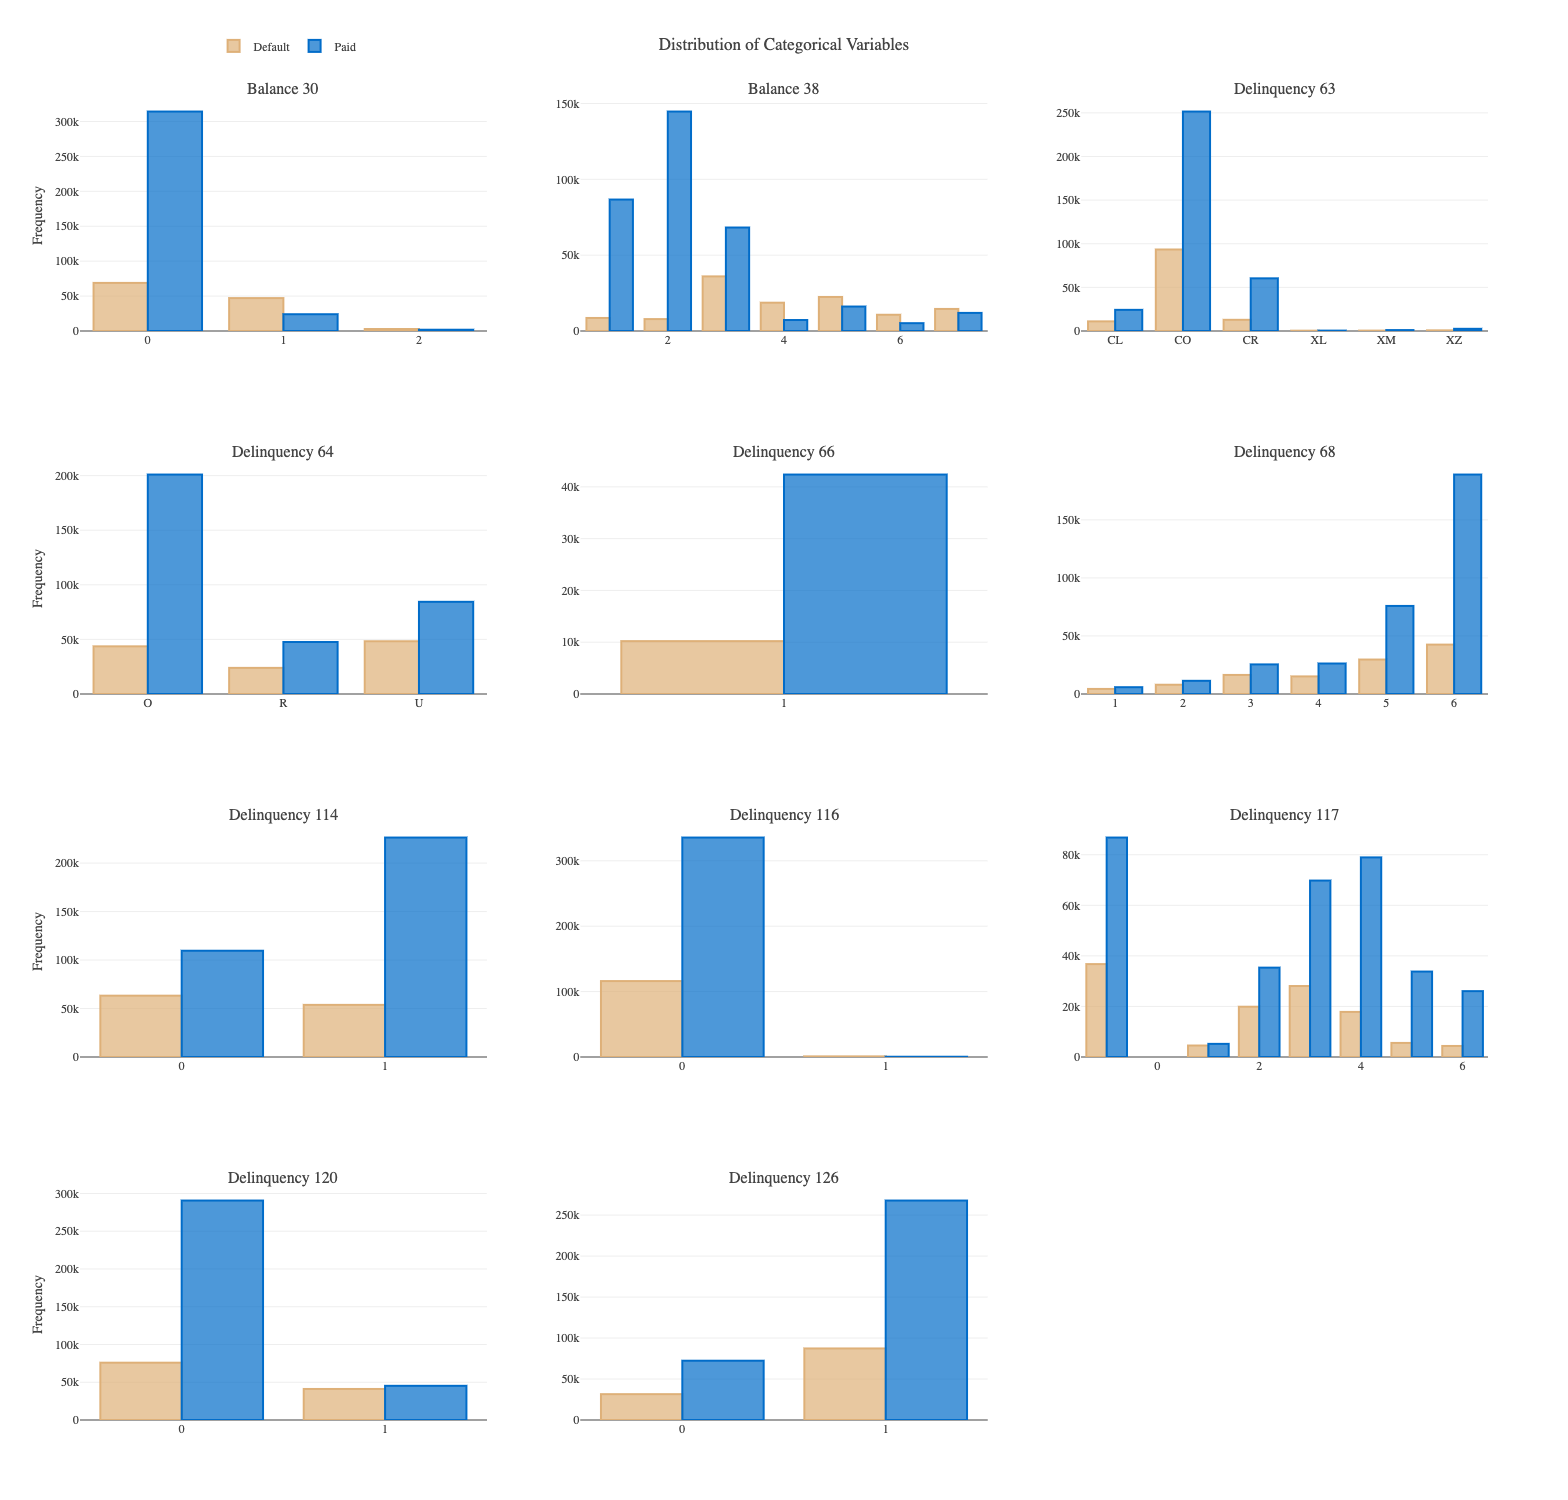

In [35]:
fig = make_subplots(rows=4, cols=3, 
                    subplot_titles=cat_cols[:-1], 
                    vertical_spacing=0.1)
row=0
c=[1,2,3]*5
plot_df=train[cat_cols]
for i,col in enumerate(cat_cols[:-1]):
    if i%3==0:
        row+=1
    plot_df[col]=plot_df[col].astype(object)
    df=plot_df.groupby(col)['Target'].value_counts().rename('count').reset_index().replace('',np.nan)
    
    fig.add_trace(go.Bar(x=df[df.Target==1][col], y=df[df.Target==1]['count'],
                         marker_color=rgb[1], marker_line=dict(color=pal[1],width=2), 
                         hovertemplate='Value %{x} Frequency = %{y}',
                         name='Default', showlegend=(True if i==0 else False)),
                  row=row, col=c[i])
    fig.add_trace(go.Bar(x=df[df.Target==0][col], y=df[df.Target==0]['count'],
                         marker_color=rgb[0], marker_line=dict(color=pal[0],width=2),
                         hovertemplate='Value %{x} Frequency = %{y}',
                         name='Paid', showlegend=(True if i==0 else False)),
                  row=row, col=c[i])
    if i%3==0:
        fig.update_yaxes(title='Frequency',row=row,col=c[i])
fig.update_layout(template=temp,title="Distribution of Categorical Variables",
                  legend=dict(orientation="h",yanchor="bottom",y=1.03,xanchor="right",x=0.2),
                  barmode='group',height=1500,width=900)
fig.show()

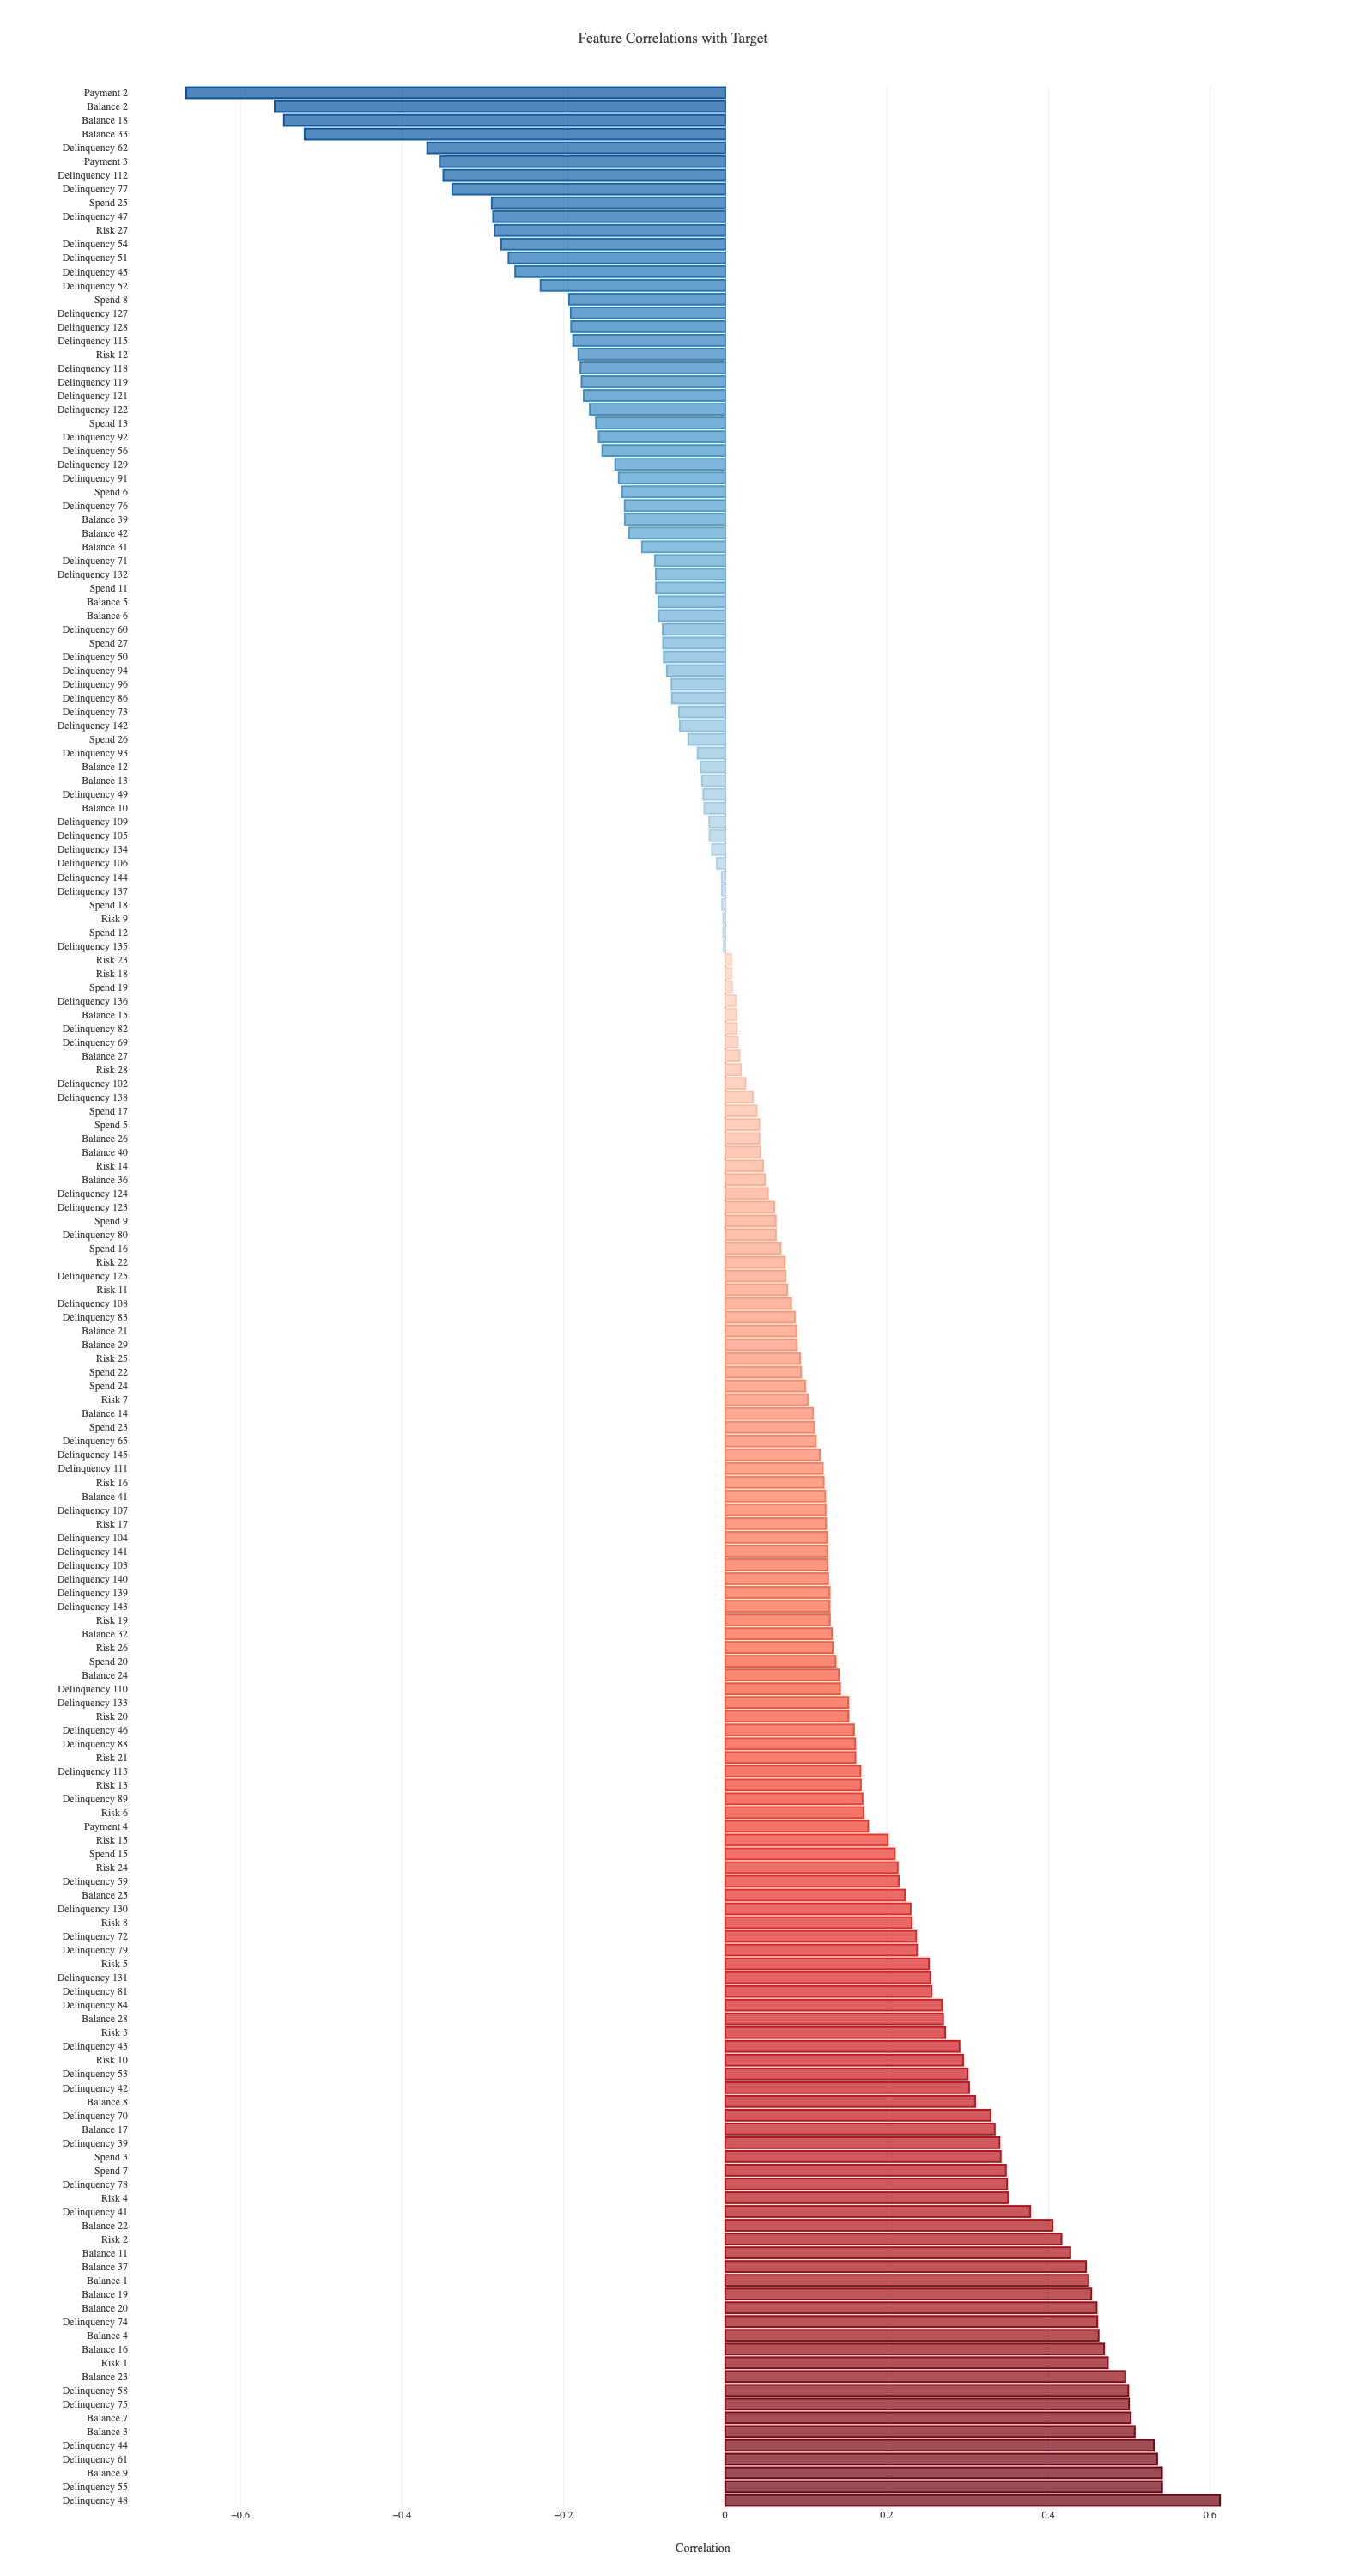

In [36]:
corr=train.corr()
corr=corr['Target'].sort_values(ascending=False)[1:-1]
pal=sns.color_palette("Reds_r",135).as_hex()
rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.7)) for i in pal]
fig = go.Figure()
fig.add_trace(go.Bar(x=corr[corr>=0], y=corr[corr>=0].index, 
                     marker_color=rgb, orientation='h', 
                     marker_line=dict(color=pal,width=2), name='',
                     hovertemplate='%{y} correlation with target: %{x:.3f}',
                     showlegend=False))
pal=sns.color_palette("Blues",100).as_hex()
rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.7)) for i in pal]
fig.add_trace(go.Bar(x=corr[corr<0], y=corr[corr<0].index, 
                     marker_color=rgb[25:], orientation='h', 
                     marker_line=dict(color=pal[25:],width=2), name='',
                     hovertemplate='%{y} correlation with target: %{x:.3f}',
                     showlegend=False))
fig.update_layout(template=temp,title="Feature Correlations with Target",
                  xaxis_title="Correlation", margin=dict(l=150),
                  height=3000, width=700, hovermode='closest')
fig.show()

There are several strong correlations with the target variable. `Payment 2` is the most negatively correlated with the probability of defaulting with a correlation of -0.67, while `Delinquency 48` is the most positively correlated overall at 0.61. `Delinquency 87` is also missing from the correlations above due to the proportion of null values. In fact, 24 of the top 30 features with missing values are in `Delinquency` variables. 

In [37]:
null=round((train.isna().sum()/train.shape[0]*100),2).sort_values(ascending=False).astype(str)+('%')
null=null.to_frame().rename(columns={0:'Missing %'})
null.head(30)

Missing %
Delinquency 87     99.86%
Delinquency 88     99.82%
Delinquency 108    99.43%
Delinquency 111     99.2%
Delinquency 110     99.2%
Balance 39         99.11%
Delinquency 73     99.08%
Balance 42         98.66%
Delinquency 136    96.43%
Delinquency 135    96.43%
Delinquency 134    96.43%
Delinquency 137    96.43%
Delinquency 138    96.43%
Risk 9             94.13%
Balance 29         94.05%
Delinquency 76     89.25%
Risk 26            88.86%
Delinquency 106    88.75%
Delinquency 132    88.72%
Delinquency 49     88.72%
Delinquency 66     88.54%
Delinquency 42     86.95%
Delinquency 142     82.5%
Delinquency 82     74.81%
Delinquency 53     71.02%
Delinquency 50     57.14%
Delinquency 105    53.52%
Delinquency 56     53.33%
Balance 17         53.27%
Delinquency 77      46.6%

# <b><span style='color:#4B4B4B'>4 |</span><span style='color:#016CC9'> Default Prediction</span></b>
Due to the proportion of missing values, as well as some of the outliers seen in the distributions, I will use LightGBM as a baseline model to predict the likelihood of default. In addition, since the target variable is slightly imbalanced, I will use Stratified K-Fold cross-validation to maintain the class distribution in each training and validation set.

The evaluation metric, $M$, for this competition is the mean of two measures of rank ordering: Normalized Gini Coefficient, $G$, and default rate captured at 4%, $D$.

<p style='text-align:center'>$M=0.5⋅(G+D)$ </p>  

The default rate captured at 4% is the percentage of the positive labels (defaults) captured within the highest-ranked 4% of the predictions, and represents a Sensitivity/Recall statistic.

For both of the sub-metrics $G$ and $D$, the negative labels are given a weight of 20 to adjust for downsampling.

This metric has a maximum value of 1.0.

Python code for calculating this metric can be found in [this Notebook](https://www.kaggle.com/code/inversion/amex-competition-metric-python).

In [45]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)


def plot_roc(y_val,y_prob):
    colors=px.colors.qualitative.Prism
    fig=go.Figure()
    fig.add_trace(go.Scatter(x=np.linspace(0,1,11), y=np.linspace(0,1,11), 
                             name='Random Chance',mode='lines', showlegend=False,
                             line=dict(color="Black", width=1, dash="dot")))
    for i in range(len(y_val)):
        y=y_val[i]
        prob=y_prob[i]
        fpr, tpr, _ = roc_curve(y, prob)
        roc_auc = auc(fpr,tpr)
        fig.add_trace(go.Scatter(x=fpr, y=tpr, line=dict(color=colors[::-1][i+1], width=3), 
                                 hovertemplate = 'True positive rate = %{y:.3f}<br>False positive rate = %{x:.3f}',
                                 name='Fold {}:  Gini = {:.3f}, AUC = {:.3f}'.format(i+1, gini[i],roc_auc)))
    fig.update_layout(template=temp, title="Cross-Validation ROC Curves", 
                      hovermode="x unified", width=700,height=600,
                      xaxis_title='False Positive Rate (1 - Specificity)',
                      yaxis_title='True Positive Rate (Sensitivity)',
                      legend=dict(orientation='v', y=.07, x=1, xanchor="right",
                                  bordercolor="black", borderwidth=.5))
    fig.show()

In [ ]:
enc = LabelEncoder()
for col in cat_cols[:-1]:
    train[col] = enc.fit_transform(train[col])
    test[col] = enc.transform(test[col])

X=train.drop(['Target'],axis=1)
y=train['Target']
y_valid, gbm_val_probs, gbm_test_preds, gini=[],[],[],[]
ft_importance=pd.DataFrame(index=X.columns)
sk_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=21)
for fold, (train_idx, val_idx) in enumerate(sk_fold.split(X, y)):
    
    print("\nFold {}".format(fold+1))
    X_train, y_train = X.iloc[train_idx,:], y[train_idx]
    X_val, y_val = X.iloc[val_idx,:], y[val_idx]
    print("Train shape: {}, {}, Valid shape: {}, {}\n".format(
        X_train.shape, y_train.shape, X_val.shape, y_val.shape))
    
    params = {'boosting_type': 'gbdt',
              'n_estimators': 1000,
              'num_leaves': 50,
              'learning_rate': 0.05,
              'colsample_bytree': 0.9,
              'min_child_samples': 2000,
              'max_bins': 500,
              'reg_alpha': 2,
              'objective': 'binary',
              'random_state': 21}
    
    gbm = LGBMClassifier(**params).fit(X_train, y_train, 
                                       eval_set=[(X_train, y_train), (X_val, y_val)],
                                       callbacks=[early_stopping(200), log_evaluation(500)],
                                       eval_metric=['auc','binary_logloss'])
    gbm_prob = gbm.predict_proba(X_val)[:,1]
    gbm_val_probs.append(gbm_prob)
    y_valid.append(y_val)
    
    y_pred=pd.DataFrame(data={'prediction':gbm_prob})
    y_true=pd.DataFrame(data={'target':y_val.reset_index(drop=True)})
    gini_score=amex_metric(y_true = y_true, y_pred = y_pred)
    gini.append(gini_score)
    
    auc_score=roc_auc_score(y_val, gbm_prob)
    gbm_test_preds.append(gbm.predict_proba(test)[:,1])    
    ft_importance["Importance_Fold"+str(fold)]=gbm.feature_importances_    
    print("Validation Gini: {:.5f}, AUC: {:.4f}".format(gini_score,auc_score))
    
    del X_train, y_train, X_val, y_val
    _ = gc.collect()
    
del X, y
plot_roc(y_valid, gbm_val_probs)


Fold 1
Train shape: (413021, 188), (413021,), Valid shape: (45892, 188), (45892,)

Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.971327	training's binary_logloss: 0.191196	valid_1's auc: 0.959852	valid_1's binary_logloss: 0.221868
[500]	training's auc: 0.971298	training's binary_logloss: 0.191223	valid_1's auc: 0.959829	valid_1's binary_logloss: 0.222303
Early stopping, best iteration is:
[530]	training's auc: 0.971893	training's binary_logloss: 0.189559	valid_1's auc: 0.959853	valid_1's binary_logloss: 0.222244
Validation Gini: 0.78309, AUC: 0.9599

Fold 3
Train shape: (413021, 188), (413021,), Valid shape: (45892, 188), (45892,)

Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.971342	training's binary_logloss: 0.19109	valid_1's auc: 0.959387	valid_1's binary_logloss: 0.223591
Early stopping, best iteration is:
[585]	training's auc: 0.972948	training's binary_logloss: 0.186547	valid_1's auc: 0.959481	valid_

# <b><div style='padding:15px;background-color:#4B4B4B;color:white;border-radius:5px;font-size:60%'>4.1 Feature Importance</div></b>
Among the top 50 features, `Payment 2` has the highest average importance, which is also the feature that is the most negatively correlated with the target variable.

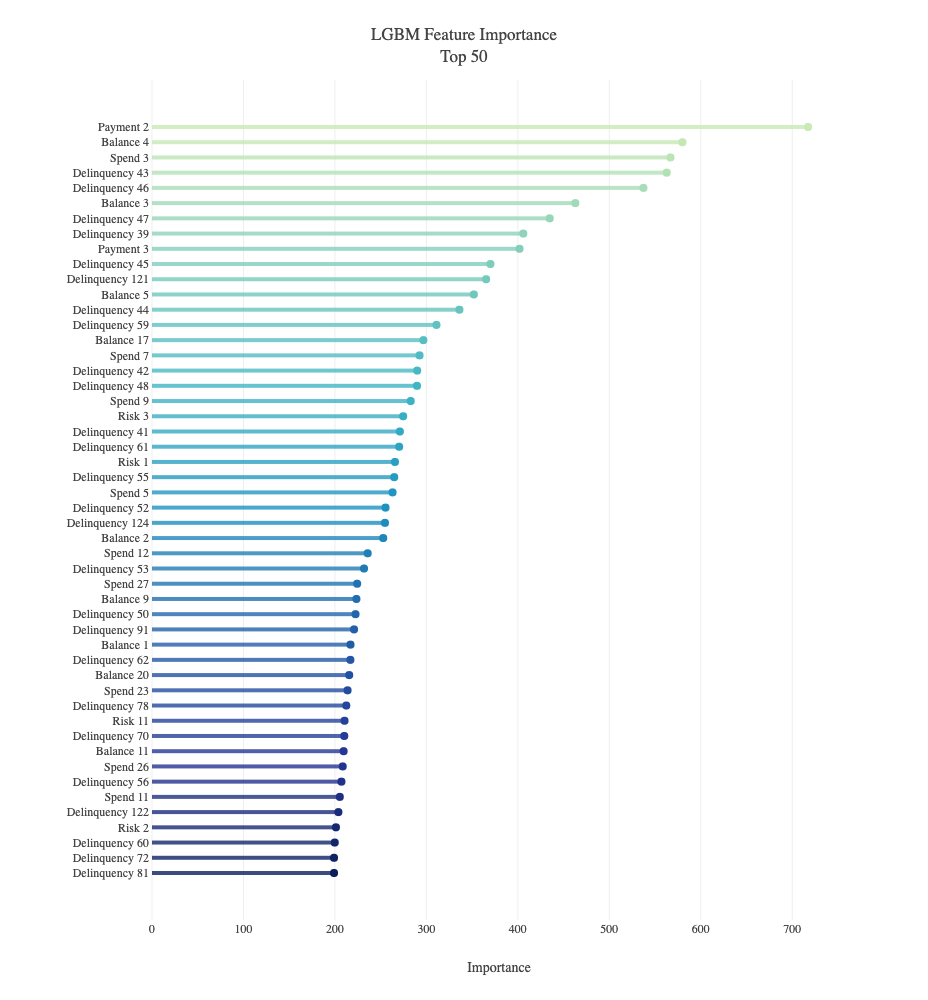

In [40]:
ft_importance['avg']=ft_importance.mean(axis=1)
ft_importance=ft_importance.avg.nlargest(50).sort_values(ascending=True)

pal=sns.color_palette("YlGnBu", 65).as_hex()
fig=go.Figure()
for i in range(len(ft_importance.index)):
    fig.add_shape(dict(type="line", y0=i, y1=i, x0=0, x1=ft_importance[i], 
                       line_color=pal[::-1][i],opacity=0.8,line_width=4))
fig.add_trace(go.Scatter(x=ft_importance, y=ft_importance.index, mode='markers', 
                         marker_color=pal[::-1], marker_size=8,
                         hovertemplate='%{y} Importance = %{x:.0f}<extra></extra>'))
fig.update_layout(template=temp,title='LGBM Feature Importance<br>Top 50', 
                  margin=dict(l=150,t=80),
                  xaxis=dict(title='Importance', zeroline=False),
                  yaxis_showgrid=False, height=1000, width=800)
fig.show()